##### Copyright 2019 The TensorFlow Neural Structured Learning Authors

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Graph regularization for sentiment classification using synthesized graphs

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/neural_structured_learning/tutorials/graph_keras_lstm_imdb"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/neural-structured-learning/blob/master/g3doc/tutorials/graph_keras_lstm_imdb.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/neural-structured-learning/blob/master/g3doc/tutorials/graph_keras_lstm_imdb.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/neural-structured-learning/g3doc/tutorials/graph_keras_lstm_imdb.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

## Overview

This notebook classifies movie reviews as *positive* or *negative* using the
text of the review. This is an example of *binary* classification, an important
and widely applicable kind of machine learning problem.

We will demonstrate the use of graph regularization in this notebook by building
a graph from the given input. The general recipe for building a
graph-regularized model using the Neural Structured Learning (NSL) framework
when the input does not contain an explicit graph is as follows:

1.  Create embeddings for each text sample in the input. This can be done using
    pre-trained models such as [word2vec](https://arxiv.org/pdf/1310.4546.pdf),
    [Swivel](https://arxiv.org/abs/1602.02215),
    [BERT](https://arxiv.org/abs/1810.04805) etc.
2.  Build a graph based on these embeddings by using a similarity metric such as
    the 'L2' distance, 'cosine' distance, etc. Nodes in the graph correspond to
    samples and edges in the graph correspond to similarity between pairs of
    samples.
3.  Generate training data from the above synthesized graph and sample features.
    The resulting training data will contain neighbor features in addition to
    the original node features.
4.  Create a neural network as a base model using the Keras sequential,
    functional, or subclass API.
5.  Wrap the base model with the GraphRegularization wrapper class, which is
    provided by the NSL framework, to create a new graph Keras model. This new
    model will include a graph regularization loss as the regularization term in
    its training objective.
6.  Train and evaluate the graph Keras model.

**Note**: We expect that it would take readers about 1 hour to go through this
tutorial.

## Requirements

1.  Install the Neural Structured Learning package.
2.  Install tensorflow-hub.

In [2]:
!pip install --quiet neural-structured-learning
!pip install --quiet tensorflow-hub

## Dependencies and imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import neural_structured_learning as nsl

import tensorflow as tf
import tensorflow_hub as hub

# Resets notebook state
tf.keras.backend.clear_session()

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print(
    "GPU is",
    "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

2022-12-14 12:19:13.551836: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 12:19:13.551949: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 12:19:13.551962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Version:  2.11.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


2022-12-14 12:19:14.770677: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## IMDB dataset

The
[IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb)
contains the text of 50,000 movie reviews from the
[Internet Movie Database](https://www.imdb.com/). These are split into 25,000
reviews for training and 25,000 reviews for testing. The training and testing
sets are *balanced*, meaning they contain an equal number of positive and
negative reviews.

In this tutorial, we will use a preprocessed version of the IMDB dataset.

### Download preprocessed IMDB dataset

The IMDB dataset comes packaged with TensorFlow. It has already been
preprocessed such that the reviews (sequences of words) have been converted to
sequences of integers, where each integer represents a specific word in a
dictionary.

The following code downloads the IMDB dataset (or uses a cached copy if it has
already been downloaded):

In [4]:
imdb = tf.keras.datasets.imdb
(pp_train_data, pp_train_labels), (pp_test_data, pp_test_labels) = (
    imdb.load_data(num_words=10000))

    8192/17464789 [..............................] - ETA: 0s

 4202496/17464789 [======>.......................] - ETA: 0s

17464789/17464789 [==============================] - 0s 0us/step


The argument `num_words=10000` keeps the top 10,000 most frequently occurring words in the training data. The rare words are discarded to keep the size of the vocabulary manageable.

### Explore the data

Let's take a moment to understand the format of the data. The dataset comes preprocessed: each example is an array of integers representing the words of the movie review. Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [5]:
print('Training entries: {}, labels: {}'.format(
    len(pp_train_data), len(pp_train_labels)))
training_samples_count = len(pp_train_data)

Training entries: 25000, labels: 25000


The text of reviews have been converted to integers, where each integer represents a specific word in a dictionary. Here's what the first review looks like:

In [6]:
print(pp_train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Movie reviews may be different lengths. The below code shows the number of words in the first and second reviews. Since inputs to a neural network must be the same length, we'll need to resolve this later.

In [7]:
len(pp_train_data[0]), len(pp_train_data[1])

(218, 189)

### Convert the integers back to words

It may be useful to know how to convert integers back to the corresponding text.
Here, we'll create a helper function to query a dictionary object that contains
the integer to string mapping:

In [8]:
def build_reverse_word_index():
  # A dictionary mapping words to an integer index
  word_index = imdb.get_word_index()

  # The first indices are reserved
  word_index = {k: (v + 3) for k, v in word_index.items()}
  word_index['<PAD>'] = 0
  word_index['<START>'] = 1
  word_index['<UNK>'] = 2  # unknown
  word_index['<UNUSED>'] = 3
  return dict((value, key) for (key, value) in word_index.items())

reverse_word_index = build_reverse_word_index()

def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

   8192/1641221 [..............................] - ETA: 0s

1641221/1641221 [==============================] - 0s 0us/step


Now we can use the `decode_review` function to display the text for the first review:

In [9]:
decode_review(pp_train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## Graph construction

Graph construction involves creating embeddings for text samples and then using
a similarity function to compare the embeddings.

Before proceeding further, we first create a directory to store artifacts
created by this tutorial.

In [10]:
!mkdir -p /tmp/imdb

### Create sample embeddings

We will use pretrained Swivel embeddings to create embeddings in the
`tf.train.Example` format for each sample in the input. We will store the
resulting embeddings in the `TFRecord` format along with an additional feature
that represents the ID of each sample. This is important and will allow us match
sample embeddings with corresponding nodes in the graph later.

In [11]:
pretrained_embedding = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1'

hub_layer = hub.KerasLayer(
    pretrained_embedding, input_shape=[], dtype=tf.string, trainable=True)

In [12]:
def _int64_feature(value):
  """Returns int64 tf.train.Feature."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value.tolist()))


def _bytes_feature(value):
  """Returns bytes tf.train.Feature."""
  return tf.train.Feature(
      bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))


def _float_feature(value):
  """Returns float tf.train.Feature."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=value.tolist()))


def create_embedding_example(word_vector, record_id):
  """Create tf.Example containing the sample's embedding and its ID."""

  text = decode_review(word_vector)

  # Shape = [batch_size,].
  sentence_embedding = hub_layer(tf.reshape(text, shape=[-1,]))

  # Flatten the sentence embedding back to 1-D.
  sentence_embedding = tf.reshape(sentence_embedding, shape=[-1])

  features = {
      'id': _bytes_feature(str(record_id)),
      'embedding': _float_feature(sentence_embedding.numpy())
  }
  return tf.train.Example(features=tf.train.Features(feature=features))


def create_embeddings(word_vectors, output_path, starting_record_id):
  record_id = int(starting_record_id)
  with tf.io.TFRecordWriter(output_path) as writer:
    for word_vector in word_vectors:
      example = create_embedding_example(word_vector, record_id)
      record_id = record_id + 1
      writer.write(example.SerializeToString())
  return record_id


# Persist TF.Example features containing embeddings for training data in
# TFRecord format.
create_embeddings(pp_train_data, '/tmp/imdb/embeddings.tfr', 0)

25000

### Build a graph

Now that we have the sample embeddings, we will use them to build a similarity
graph, i.e, nodes in this graph will correspond to samples and edges in this
graph will correspond to similarity between pairs of nodes.

Neural Structured Learning provides a graph building library to build a graph
based on sample embeddings. It uses
[**cosine similarity**](https://en.wikipedia.org/wiki/Cosine_similarity) as the
similarity measure to compare embeddings and build edges between them. It also
allows us to specify a similarity threshold, which can be used to discard
dissimilar edges from the final graph. In this example, using 0.99 as the
similarity threshold and 12345 as the random seed, we end up with a graph that
has 429,415 bi-directional edges. Here we're using the graph builder's support
for [locality-sensitive hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing)
(LSH) to speed up graph building. For details on using the graph builder's LSH
support, see the
[`build_graph_from_config`](https://www.tensorflow.org/neural_structured_learning/api_docs/python/nsl/tools/build_graph_from_config)
API documentation.

In [13]:
graph_builder_config = nsl.configs.GraphBuilderConfig(
    similarity_threshold=0.99, lsh_splits=32, lsh_rounds=15, random_seed=12345)
nsl.tools.build_graph_from_config(['/tmp/imdb/embeddings.tfr'],
                                  '/tmp/imdb/graph_99.tsv',
                                  graph_builder_config)

Each bi-directional edge is represented by two directed edges in the output TSV
file, so that file contains 429,415 * 2 = 858,830 total lines:

In [14]:
!wc -l /tmp/imdb/graph_99.tsv

858830 /tmp/imdb/graph_99.tsv


**Note:** Graph quality and by extension, embedding quality, are very important
for graph regularization. While we have used Swivel embeddings in this notebook,
using BERT embeddings for instance, will likely capture review semantics more
accurately. We encourage users to use embeddings of their choice and as
appropriate to their needs.

## Sample features

We create sample features for our problem using the `tf.train.Example` format
and persist them in the `TFRecord` format. Each sample will include the
following three features:

1.  **id**: The node ID of the sample.
2.  **words**: An int64 list containing word IDs.
3.  **label**: A singleton int64 identifying the target class of the review.

In [15]:
def create_example(word_vector, label, record_id):
  """Create tf.Example containing the sample's word vector, label, and ID."""
  features = {
      'id': _bytes_feature(str(record_id)),
      'words': _int64_feature(np.asarray(word_vector)),
      'label': _int64_feature(np.asarray([label])),
  }
  return tf.train.Example(features=tf.train.Features(feature=features))

def create_records(word_vectors, labels, record_path, starting_record_id):
  record_id = int(starting_record_id)
  with tf.io.TFRecordWriter(record_path) as writer:
    for word_vector, label in zip(word_vectors, labels):
      example = create_example(word_vector, label, record_id)
      record_id = record_id + 1
      writer.write(example.SerializeToString())
  return record_id

# Persist TF.Example features (word vectors and labels) for training and test
# data in TFRecord format.
next_record_id = create_records(pp_train_data, pp_train_labels,
                                '/tmp/imdb/train_data.tfr', 0)
create_records(pp_test_data, pp_test_labels, '/tmp/imdb/test_data.tfr',
               next_record_id)

50000

## Augment training data with graph neighbors

Since we have the sample features and the synthesized graph, we can generate the
augmented training data for Neural Structured Learning. The NSL framework
provides a library to combine the graph and the sample features to produce
the final training data for graph regularization. The resulting training data
will include original sample features as well as features of their corresponding
neighbors.

In this tutorial, we consider undirected edges and use a maximum of 3 neighbors
per sample to augment training data with graph neighbors.

In [16]:
nsl.tools.pack_nbrs(
    '/tmp/imdb/train_data.tfr',
    '',
    '/tmp/imdb/graph_99.tsv',
    '/tmp/imdb/nsl_train_data.tfr',
    add_undirected_edges=True,
    max_nbrs=3)

## Base model

We are now ready to build a base model without graph regularization. In order to
build this model, we can either use embeddings that were used in building the
graph, or we can learn new embeddings jointly along with the classification
task. For the purpose of this notebook, we will do the latter.

### Global variables

In [17]:
NBR_FEATURE_PREFIX = 'NL_nbr_'
NBR_WEIGHT_SUFFIX = '_weight'

### Hyperparameters

We will use an instance of `HParams` to inclue various hyperparameters and
constants used for training and evaluation. We briefly describe each of them
below:

-   **num_classes**: There are 2 classes -- *positive* and *negative*.

-   **max_seq_length**: This is the maximum number of words considered from each
    movie review in this example.

-   **vocab_size**: This is the size of the vocabulary considered for this
    example.

-   **distance_type**: This is the distance metric used to regularize the sample
    with its neighbors.

-   **graph_regularization_multiplier**: This controls the relative weight of
    the graph regularization term in the overall loss function.

-   **num_neighbors**: The number of neighbors used for graph regularization.
    This value has to be less than or equal to the `max_nbrs` argument used
    above when invoking `nsl.tools.pack_nbrs`.

-   **num_fc_units**: The number of units in the fully connected layer of the
    neural network.

-   **train_epochs**: The number of training epochs.

-   **batch_size**: Batch size used for training and evaluation.

-   **eval_steps**: The number of batches to process before deeming evaluation
    is complete. If set to `None`, all instances in the test set are evaluated.

In [18]:
class HParams(object):
  """Hyperparameters used for training."""
  def __init__(self):
    ### dataset parameters
    self.num_classes = 2
    self.max_seq_length = 256
    self.vocab_size = 10000
    ### neural graph learning parameters
    self.distance_type = nsl.configs.DistanceType.L2
    self.graph_regularization_multiplier = 0.1
    self.num_neighbors = 2
    ### model architecture
    self.num_embedding_dims = 16
    self.num_lstm_dims = 64
    self.num_fc_units = 64
    ### training parameters
    self.train_epochs = 10
    self.batch_size = 128
    ### eval parameters
    self.eval_steps = None  # All instances in the test set are evaluated.

HPARAMS = HParams()

### Prepare the data

The reviews—the arrays of integers—must be converted to tensors before being fed
into the neural network. This conversion can be done a couple of ways:

*   Convert the arrays into vectors of `0`s and `1`s indicating word occurrence,
    similar to a one-hot encoding. For example, the sequence `[3, 5]` would         become a `10000`-dimensional vector that is all zeros except for indices        `3` and `5`, which are ones. Then, make this the first layer in our             network—a `Dense` layer—that can handle floating point vector data. This        approach is memory intensive, though, requiring a `num_words * num_reviews`     size matrix.

*   Alternatively, we can pad the arrays so they all have the same length, then
    create an integer tensor of shape `max_length * num_reviews`. We can use an
    embedding layer capable of handling this shape as the first layer in our
    network.

In this tutorial, we will use the second approach.

Since the movie reviews must be the same length, we will use the `pad_sequence`
function defined below to standardize the lengths.

In [19]:
def make_dataset(file_path, training=False):
  """Creates a `tf.data.TFRecordDataset`.

  Args:
    file_path: Name of the file in the `.tfrecord` format containing
      `tf.train.Example` objects.
    training: Boolean indicating if we are in training mode.

  Returns:
    An instance of `tf.data.TFRecordDataset` containing the `tf.train.Example`
    objects.
  """

  def pad_sequence(sequence, max_seq_length):
    """Pads the input sequence (a `tf.SparseTensor`) to `max_seq_length`."""
    pad_size = tf.maximum([0], max_seq_length - tf.shape(sequence)[0])
    padded = tf.concat(
        [sequence.values,
         tf.fill((pad_size), tf.cast(0, sequence.dtype))],
        axis=0)
    # The input sequence may be larger than max_seq_length. Truncate down if
    # necessary.
    return tf.slice(padded, [0], [max_seq_length])

  def parse_example(example_proto):
    """Extracts relevant fields from the `example_proto`.

    Args:
      example_proto: An instance of `tf.train.Example`.

    Returns:
      A pair whose first value is a dictionary containing relevant features
      and whose second value contains the ground truth labels.
    """
    # The 'words' feature is a variable length word ID vector.
    feature_spec = {
        'words': tf.io.VarLenFeature(tf.int64),
        'label': tf.io.FixedLenFeature((), tf.int64, default_value=-1),
    }
    # We also extract corresponding neighbor features in a similar manner to
    # the features above during training.
    if training:
      for i in range(HPARAMS.num_neighbors):
        nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, i, 'words')
        nbr_weight_key = '{}{}{}'.format(NBR_FEATURE_PREFIX, i,
                                         NBR_WEIGHT_SUFFIX)
        feature_spec[nbr_feature_key] = tf.io.VarLenFeature(tf.int64)

        # We assign a default value of 0.0 for the neighbor weight so that
        # graph regularization is done on samples based on their exact number
        # of neighbors. In other words, non-existent neighbors are discounted.
        feature_spec[nbr_weight_key] = tf.io.FixedLenFeature(
            [1], tf.float32, default_value=tf.constant([0.0]))

    features = tf.io.parse_single_example(example_proto, feature_spec)

    # Since the 'words' feature is a variable length word vector, we pad it to a
    # constant maximum length based on HPARAMS.max_seq_length
    features['words'] = pad_sequence(features['words'], HPARAMS.max_seq_length)
    if training:
      for i in range(HPARAMS.num_neighbors):
        nbr_feature_key = '{}{}_{}'.format(NBR_FEATURE_PREFIX, i, 'words')
        features[nbr_feature_key] = pad_sequence(features[nbr_feature_key],
                                                 HPARAMS.max_seq_length)

    labels = features.pop('label')
    return features, labels

  dataset = tf.data.TFRecordDataset([file_path])
  if training:
    dataset = dataset.shuffle(10000)
  dataset = dataset.map(parse_example)
  dataset = dataset.batch(HPARAMS.batch_size)
  return dataset


train_dataset = make_dataset('/tmp/imdb/nsl_train_data.tfr', True)
test_dataset = make_dataset('/tmp/imdb/test_data.tfr')

### Build the model

A neural network is created by stacking layers—this requires two main architectural decisions:

* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of an array of word-indices. The labels to predict are either 0 or 1.

We will use a bi-directional LSTM as our base model in this tutorial.

In [20]:
# This function exists as an alternative to the bi-LSTM model used in this
# notebook.
def make_feed_forward_model():
  """Builds a simple 2 layer feed forward neural network."""
  inputs = tf.keras.Input(
      shape=(HPARAMS.max_seq_length,), dtype='int64', name='words')
  embedding_layer = tf.keras.layers.Embedding(HPARAMS.vocab_size, 16)(inputs)
  pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(embedding_layer)
  dense_layer = tf.keras.layers.Dense(16, activation='relu')(pooling_layer)
  outputs = tf.keras.layers.Dense(1)(dense_layer)
  return tf.keras.Model(inputs=inputs, outputs=outputs)


def make_bilstm_model():
  """Builds a bi-directional LSTM model."""
  inputs = tf.keras.Input(
      shape=(HPARAMS.max_seq_length,), dtype='int64', name='words')
  embedding_layer = tf.keras.layers.Embedding(HPARAMS.vocab_size,
                                              HPARAMS.num_embedding_dims)(
                                                  inputs)
  lstm_layer = tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(HPARAMS.num_lstm_dims))(
          embedding_layer)
  dense_layer = tf.keras.layers.Dense(
      HPARAMS.num_fc_units, activation='relu')(
          lstm_layer)
  outputs = tf.keras.layers.Dense(1)(dense_layer)
  return tf.keras.Model(inputs=inputs, outputs=outputs)


# Feel free to use an architecture of your choice.
model = make_bilstm_model()
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 words (InputLayer)          [(None, 256)]             0         


 embedding (Embedding)       (None, 256, 16)           160000    


 bidirectional (Bidirectiona  (None, 128)              41472     


 l)                                                              


 dense (Dense)               (None, 64)                8256      


 dense_1 (Dense)             (None, 1)                 65        


Total params: 209,793


Trainable params: 209,793


Non-trainable params: 0


_________________________________________________________________


The layers are effectively stacked sequentially to build the classifier:

1.  The first layer is an `Input` layer which takes the integer-encoded
    vocabulary.
2.  The next layer is an `Embedding` layer, which takes the integer-encoded
    vocabulary and looks up the embedding vector for each word-index. These
    vectors are learned as the model trains. The vectors add a dimension to the
    output array. The resulting dimensions are: `(batch, sequence, embedding)`.
3.  Next, a bidirectional LSTM layer returns a fixed-length output vector for
    each example.
4.  This fixed-length output vector is piped through a fully-connected (`Dense`)
    layer with 64 hidden units.
5.  The last layer is densely connected with a single output node. Using the
    `sigmoid` activation function, this value is a float between 0 and 1,
    representing a probability, or confidence level.

### Hidden units

The above model has two intermediate or "hidden" layers, between the input and
output, and excluding the `Embedding` layer. The number of outputs (units,
nodes, or neurons) is the dimension of the representational space for the layer.
In other words, the amount of freedom the network is allowed when learning an
internal representation.

If a model has more hidden units (a higher-dimensional representation space),
and/or more layers, then the network can learn more complex representations.
However, it makes the network more computationally expensive and may lead to
learning unwanted patterns—patterns that improve performance on training data
but not on the test data. This is called *overfitting*.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a
binary classification problem and the model outputs a probability (a single-unit
layer with a sigmoid activation), we'll use the `binary_crossentropy` loss
function.

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

### Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen
before. Create a *validation set* by setting apart a fraction of the original
training data. (Why not use the testing set now? Our goal is to develop and tune
our model using only the training data, then use the test data just once to
evaluate our accuracy).

In this tutorial, we take roughly 10% of the initial training samples (10% of 25000) as labeled data for training and the remaining as validation data. Since the initial train/test split was 50/50 (25000 samples each), the effective train/validation/test split we now have is 5/45/50.

Note that 'train_dataset' has already been batched and shuffled. 

In [22]:
validation_fraction = 0.9
validation_size = int(validation_fraction *
                      int(training_samples_count / HPARAMS.batch_size))
print(validation_size)
validation_dataset = train_dataset.take(validation_size)
train_dataset = train_dataset.skip(validation_size)

175


### Train the model

Train the model in mini-batches. While training, monitor the model's loss and accuracy on the validation set:

In [23]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=HPARAMS.train_epochs,
    verbose=1)

Epoch 1/10


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['NL_nbr_0_words', 'NL_nbr_1_words', 'NL_nbr_0_weight', 'NL_nbr_1_weight'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


      1/Unknown - 5s 5s/step - loss: 0.6936 - accuracy: 0.4453

      2/Unknown - 5s 177ms/step - loss: 0.6934 - accuracy: 0.4805

      3/Unknown - 5s 169ms/step - loss: 0.6932 - accuracy: 0.5000

      4/Unknown - 5s 165ms/step - loss: 0.6933 - accuracy: 0.4980

      5/Unknown - 5s 164ms/step - loss: 0.6932 - accuracy: 0.5109

      6/Unknown - 5s 162ms/step - loss: 0.6935 - accuracy: 0.4974

      7/Unknown - 6s 162ms/step - loss: 0.6933 - accuracy: 0.5022

      8/Unknown - 6s 161ms/step - loss: 0.6935 - accuracy: 0.4893

      9/Unknown - 6s 160ms/step - loss: 0.6934 - accuracy: 0.4922

     10/Unknown - 6s 160ms/step - loss: 0.6934 - accuracy: 0.4906

     11/Unknown - 6s 160ms/step - loss: 0.6933 - accuracy: 0.4886

     12/Unknown - 6s 159ms/step - loss: 0.6932 - accuracy: 0.4863

     13/Unknown - 7s 159ms/step - loss: 0.6932 - accuracy: 0.4844

     14/Unknown - 7s 159ms/step - loss: 0.6932 - accuracy: 0.4872

     15/Unknown - 7s 159ms/step - loss: 0.6932 - accuracy: 0.4911

     16/Unknown - 7s 159ms/step - loss: 0.6932 - accuracy: 0.4907

     17/Unknown - 7s 158ms/step - loss: 0.6931 - accuracy: 0.4903

     18/Unknown - 7s 158ms/step - loss: 0.6930 - accuracy: 0.4878

     19/Unknown - 8s 158ms/step - loss: 0.6928 - accuracy: 0.4864

     20/Unknown - 8s 158ms/step - loss: 0.6928 - accuracy: 0.4840

     21/Unknown - 8s 154ms/step - loss: 0.6928 - accuracy: 0.4850

21/21 [==============================] - 20s 790ms/step - loss: 0.6928 - accuracy: 0.4850 - val_loss: 0.6927 - val_accuracy: 0.5001


Epoch 2/10


 1/21 [>.............................] - ETA: 11s - loss: 0.6911 - accuracy: 0.4922

 2/21 [=>............................] - ETA: 2s - loss: 0.6916 - accuracy: 0.5000 

 3/21 [===>..........................] - ETA: 2s - loss: 0.6920 - accuracy: 0.5078

 4/21 [====>.........................] - ETA: 2s - loss: 0.6916 - accuracy: 0.4941

 5/21 [======>.......................] - ETA: 2s - loss: 0.6919 - accuracy: 0.5016

 6/21 [=======>......................] - ETA: 2s - loss: 0.6915 - accuracy: 0.4948

 7/21 [=========>....................] - ETA: 2s - loss: 0.6913 - accuracy: 0.4944

 8/21 [==========>...................] - ETA: 2s - loss: 0.6913 - accuracy: 0.5000

 9/21 [===========>..................] - ETA: 1s - loss: 0.6911 - accuracy: 0.5017

10/21 [=============>................] - ETA: 1s - loss: 0.6909 - accuracy: 0.5063

11/21 [==============>...............] - ETA: 1s - loss: 0.6906 - accuracy: 0.5021

12/21 [================>.............] - ETA: 1s - loss: 0.6907 - accuracy: 0.4987

13/21 [=================>............] - ETA: 1s - loss: 0.6905 - accuracy: 0.5000

14/21 [===================>..........] - ETA: 1s - loss: 0.6901 - accuracy: 0.4994

15/21 [====================>.........] - ETA: 0s - loss: 0.6897 - accuracy: 0.5016

16/21 [=====================>........] - ETA: 0s - loss: 0.6891 - accuracy: 0.5039

17/21 [=======================>......] - ETA: 0s - loss: 0.6893 - accuracy: 0.5041

18/21 [========================>.....] - ETA: 0s - loss: 0.6884 - accuracy: 0.5048

19/21 [==========================>...] - ETA: 0s - loss: 0.6865 - accuracy: 0.5025

20/21 [===========================>..] - ETA: 0s - loss: 0.6852 - accuracy: 0.5012

21/21 [==============================] - ETA: 0s - loss: 0.6847 - accuracy: 0.5019

21/21 [==============================] - 15s 739ms/step - loss: 0.6847 - accuracy: 0.5019 - val_loss: 0.6387 - val_accuracy: 0.5028


Epoch 3/10


 1/21 [>.............................] - ETA: 12s - loss: 0.6426 - accuracy: 0.4609

 2/21 [=>............................] - ETA: 2s - loss: 0.6260 - accuracy: 0.5664 

 3/21 [===>..........................] - ETA: 2s - loss: 0.6241 - accuracy: 0.5781

 4/21 [====>.........................] - ETA: 2s - loss: 0.6599 - accuracy: 0.5820

 5/21 [======>.......................] - ETA: 2s - loss: 0.6760 - accuracy: 0.5813

 6/21 [=======>......................] - ETA: 2s - loss: 0.6748 - accuracy: 0.6016

 7/21 [=========>....................] - ETA: 2s - loss: 0.6675 - accuracy: 0.5893

 8/21 [==========>...................] - ETA: 2s - loss: 0.6649 - accuracy: 0.5830

 9/21 [===========>..................] - ETA: 1s - loss: 0.6632 - accuracy: 0.5773

10/21 [=============>................] - ETA: 1s - loss: 0.6629 - accuracy: 0.5711

11/21 [==============>...............] - ETA: 1s - loss: 0.6631 - accuracy: 0.5625

12/21 [================>.............] - ETA: 1s - loss: 0.6630 - accuracy: 0.5566

13/21 [=================>............] - ETA: 1s - loss: 0.6640 - accuracy: 0.5493

14/21 [===================>..........] - ETA: 1s - loss: 0.6643 - accuracy: 0.5463

15/21 [====================>.........] - ETA: 0s - loss: 0.6672 - accuracy: 0.5328

16/21 [=====================>........] - ETA: 0s - loss: 0.6662 - accuracy: 0.5366

17/21 [=======================>......] - ETA: 0s - loss: 0.6658 - accuracy: 0.5340

18/21 [========================>.....] - ETA: 0s - loss: 0.6652 - accuracy: 0.5352

19/21 [==========================>...] - ETA: 0s - loss: 0.6644 - accuracy: 0.5370

20/21 [===========================>..] - ETA: 0s - loss: 0.6647 - accuracy: 0.5328

21/21 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.5350

21/21 [==============================] - 15s 741ms/step - loss: 0.6641 - accuracy: 0.5350 - val_loss: 0.6572 - val_accuracy: 0.5002


Epoch 4/10


 1/21 [>.............................] - ETA: 12s - loss: 0.6663 - accuracy: 0.4297

 2/21 [=>............................] - ETA: 3s - loss: 0.6604 - accuracy: 0.4844 

 3/21 [===>..........................] - ETA: 2s - loss: 0.6582 - accuracy: 0.4792

 4/21 [====>.........................] - ETA: 2s - loss: 0.6528 - accuracy: 0.4883

 5/21 [======>.......................] - ETA: 2s - loss: 0.6485 - accuracy: 0.5000

 6/21 [=======>......................] - ETA: 2s - loss: 0.6472 - accuracy: 0.5039

 7/21 [=========>....................] - ETA: 2s - loss: 0.6451 - accuracy: 0.4989

 8/21 [==========>...................] - ETA: 2s - loss: 0.6450 - accuracy: 0.5010

 9/21 [===========>..................] - ETA: 1s - loss: 0.6430 - accuracy: 0.5000

10/21 [=============>................] - ETA: 1s - loss: 0.6442 - accuracy: 0.4984

11/21 [==============>...............] - ETA: 1s - loss: 0.6414 - accuracy: 0.5000

12/21 [================>.............] - ETA: 1s - loss: 0.6376 - accuracy: 0.5013

13/21 [=================>............] - ETA: 1s - loss: 0.6343 - accuracy: 0.4976

14/21 [===================>..........] - ETA: 1s - loss: 0.6294 - accuracy: 0.4950

15/21 [====================>.........] - ETA: 0s - loss: 0.6253 - accuracy: 0.4953

16/21 [=====================>........] - ETA: 0s - loss: 0.6200 - accuracy: 0.5020

17/21 [=======================>......] - ETA: 0s - loss: 0.6158 - accuracy: 0.5147

18/21 [========================>.....] - ETA: 0s - loss: 0.6132 - accuracy: 0.5265

19/21 [==========================>...] - ETA: 0s - loss: 0.6095 - accuracy: 0.5345

20/21 [===========================>..] - ETA: 0s - loss: 0.6048 - accuracy: 0.5469

21/21 [==============================] - ETA: 0s - loss: 0.6083 - accuracy: 0.5504

21/21 [==============================] - 15s 740ms/step - loss: 0.6083 - accuracy: 0.5504 - val_loss: 0.5291 - val_accuracy: 0.7685


Epoch 5/10


 1/21 [>.............................] - ETA: 11s - loss: 0.5490 - accuracy: 0.7656

 2/21 [=>............................] - ETA: 2s - loss: 0.5387 - accuracy: 0.7695 

 3/21 [===>..........................] - ETA: 2s - loss: 0.5384 - accuracy: 0.7474

 4/21 [====>.........................] - ETA: 2s - loss: 0.5268 - accuracy: 0.7383

 5/21 [======>.......................] - ETA: 2s - loss: 0.5101 - accuracy: 0.7266

 6/21 [=======>......................] - ETA: 2s - loss: 0.5293 - accuracy: 0.7214

 7/21 [=========>....................] - ETA: 2s - loss: 0.5221 - accuracy: 0.7121

 8/21 [==========>...................] - ETA: 2s - loss: 0.5197 - accuracy: 0.7148

 9/21 [===========>..................] - ETA: 1s - loss: 0.5164 - accuracy: 0.7266

10/21 [=============>................] - ETA: 1s - loss: 0.5164 - accuracy: 0.7352

11/21 [==============>...............] - ETA: 1s - loss: 0.5193 - accuracy: 0.7401

12/21 [================>.............] - ETA: 1s - loss: 0.5113 - accuracy: 0.7500

13/21 [=================>............] - ETA: 1s - loss: 0.5085 - accuracy: 0.7494

14/21 [===================>..........] - ETA: 1s - loss: 0.5075 - accuracy: 0.7478

15/21 [====================>.........] - ETA: 0s - loss: 0.5025 - accuracy: 0.7479

16/21 [=====================>........] - ETA: 0s - loss: 0.4962 - accuracy: 0.7534

17/21 [=======================>......] - ETA: 0s - loss: 0.4955 - accuracy: 0.7574

18/21 [========================>.....] - ETA: 0s - loss: 0.4979 - accuracy: 0.7561

19/21 [==========================>...] - ETA: 0s - loss: 0.4933 - accuracy: 0.7611

20/21 [===========================>..] - ETA: 0s - loss: 0.4929 - accuracy: 0.7625

21/21 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.7635

21/21 [==============================] - 15s 742ms/step - loss: 0.4911 - accuracy: 0.7635 - val_loss: 0.4327 - val_accuracy: 0.8143


Epoch 6/10


 1/21 [>.............................] - ETA: 11s - loss: 0.3969 - accuracy: 0.8281

 2/21 [=>............................] - ETA: 2s - loss: 0.3947 - accuracy: 0.8398 

 3/21 [===>..........................] - ETA: 2s - loss: 0.4379 - accuracy: 0.8151

 4/21 [====>.........................] - ETA: 2s - loss: 0.4397 - accuracy: 0.8223

 5/21 [======>.......................] - ETA: 2s - loss: 0.4330 - accuracy: 0.8219

 6/21 [=======>......................] - ETA: 2s - loss: 0.4219 - accuracy: 0.8307

 7/21 [=========>....................] - ETA: 2s - loss: 0.4209 - accuracy: 0.8304

 8/21 [==========>...................] - ETA: 2s - loss: 0.4186 - accuracy: 0.8271

 9/21 [===========>..................] - ETA: 1s - loss: 0.4233 - accuracy: 0.8247

10/21 [=============>................] - ETA: 1s - loss: 0.4198 - accuracy: 0.8211

11/21 [==============>...............] - ETA: 1s - loss: 0.4140 - accuracy: 0.8246

12/21 [================>.............] - ETA: 1s - loss: 0.4133 - accuracy: 0.8275

13/21 [=================>............] - ETA: 1s - loss: 0.4139 - accuracy: 0.8281

14/21 [===================>..........] - ETA: 1s - loss: 0.4166 - accuracy: 0.8265

15/21 [====================>.........] - ETA: 0s - loss: 0.4113 - accuracy: 0.8281

16/21 [=====================>........] - ETA: 0s - loss: 0.4085 - accuracy: 0.8281

17/21 [=======================>......] - ETA: 0s - loss: 0.4048 - accuracy: 0.8286

18/21 [========================>.....] - ETA: 0s - loss: 0.3959 - accuracy: 0.8312

19/21 [==========================>...] - ETA: 0s - loss: 0.3942 - accuracy: 0.8318

20/21 [===========================>..] - ETA: 0s - loss: 0.3923 - accuracy: 0.8301

21/21 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.8304

21/21 [==============================] - 15s 741ms/step - loss: 0.3924 - accuracy: 0.8304 - val_loss: 0.3821 - val_accuracy: 0.8529


Epoch 7/10


 1/21 [>.............................] - ETA: 11s - loss: 0.4174 - accuracy: 0.8516

 2/21 [=>............................] - ETA: 2s - loss: 0.3693 - accuracy: 0.8594 

 3/21 [===>..........................] - ETA: 2s - loss: 0.3881 - accuracy: 0.8438

 4/21 [====>.........................] - ETA: 2s - loss: 0.3750 - accuracy: 0.8516

 5/21 [======>.......................] - ETA: 2s - loss: 0.3749 - accuracy: 0.8469

 6/21 [=======>......................] - ETA: 2s - loss: 0.3688 - accuracy: 0.8529

 7/21 [=========>....................] - ETA: 2s - loss: 0.3742 - accuracy: 0.8504

 8/21 [==========>...................] - ETA: 2s - loss: 0.3718 - accuracy: 0.8496

 9/21 [===========>..................] - ETA: 1s - loss: 0.3722 - accuracy: 0.8472

10/21 [=============>................] - ETA: 1s - loss: 0.3626 - accuracy: 0.8484

11/21 [==============>...............] - ETA: 1s - loss: 0.3656 - accuracy: 0.8438

12/21 [================>.............] - ETA: 1s - loss: 0.3574 - accuracy: 0.8490

13/21 [=================>............] - ETA: 1s - loss: 0.3532 - accuracy: 0.8522

14/21 [===================>..........] - ETA: 1s - loss: 0.3527 - accuracy: 0.8510

15/21 [====================>.........] - ETA: 0s - loss: 0.3536 - accuracy: 0.8521

16/21 [=====================>........] - ETA: 0s - loss: 0.3506 - accuracy: 0.8555

17/21 [=======================>......] - ETA: 0s - loss: 0.3511 - accuracy: 0.8552

18/21 [========================>.....] - ETA: 0s - loss: 0.3480 - accuracy: 0.8585

19/21 [==========================>...] - ETA: 0s - loss: 0.3455 - accuracy: 0.8606

20/21 [===========================>..] - ETA: 0s - loss: 0.3452 - accuracy: 0.8613

21/21 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.8612

21/21 [==============================] - 15s 746ms/step - loss: 0.3449 - accuracy: 0.8612 - val_loss: 0.3550 - val_accuracy: 0.8145


Epoch 8/10


 1/21 [>.............................] - ETA: 11s - loss: 0.3601 - accuracy: 0.8203

 2/21 [=>............................] - ETA: 3s - loss: 0.3360 - accuracy: 0.8164 

 3/21 [===>..........................] - ETA: 2s - loss: 0.3377 - accuracy: 0.8177

 4/21 [====>.........................] - ETA: 2s - loss: 0.3117 - accuracy: 0.8438

 5/21 [======>.......................] - ETA: 2s - loss: 0.3033 - accuracy: 0.8547

 6/21 [=======>......................] - ETA: 2s - loss: 0.2880 - accuracy: 0.8659

 7/21 [=========>....................] - ETA: 2s - loss: 0.2977 - accuracy: 0.8672

 8/21 [==========>...................] - ETA: 2s - loss: 0.2961 - accuracy: 0.8721

 9/21 [===========>..................] - ETA: 1s - loss: 0.2896 - accuracy: 0.8767

10/21 [=============>................] - ETA: 1s - loss: 0.2917 - accuracy: 0.8750

11/21 [==============>...............] - ETA: 1s - loss: 0.2956 - accuracy: 0.8743

12/21 [================>.............] - ETA: 1s - loss: 0.2989 - accuracy: 0.8743

13/21 [=================>............] - ETA: 1s - loss: 0.2966 - accuracy: 0.8768

14/21 [===================>..........] - ETA: 1s - loss: 0.2938 - accuracy: 0.8783

15/21 [====================>.........] - ETA: 0s - loss: 0.3030 - accuracy: 0.8719

16/21 [=====================>........] - ETA: 0s - loss: 0.3039 - accuracy: 0.8721

17/21 [=======================>......] - ETA: 0s - loss: 0.3020 - accuracy: 0.8741

18/21 [========================>.....] - ETA: 0s - loss: 0.2995 - accuracy: 0.8763

19/21 [==========================>...] - ETA: 0s - loss: 0.2960 - accuracy: 0.8787

20/21 [===========================>..] - ETA: 0s - loss: 0.2977 - accuracy: 0.8789

21/21 [==============================] - ETA: 0s - loss: 0.2954 - accuracy: 0.8796

21/21 [==============================] - 16s 753ms/step - loss: 0.2954 - accuracy: 0.8796 - val_loss: 0.3103 - val_accuracy: 0.8671


Epoch 9/10


 1/21 [>.............................] - ETA: 11s - loss: 0.4600 - accuracy: 0.8125

 2/21 [=>............................] - ETA: 3s - loss: 0.3640 - accuracy: 0.8672 

 3/21 [===>..........................] - ETA: 2s - loss: 0.3205 - accuracy: 0.8880

 4/21 [====>.........................] - ETA: 2s - loss: 0.3127 - accuracy: 0.8965

 5/21 [======>.......................] - ETA: 2s - loss: 0.3108 - accuracy: 0.8922

 6/21 [=======>......................] - ETA: 2s - loss: 0.3078 - accuracy: 0.8932

 7/21 [=========>....................] - ETA: 2s - loss: 0.3065 - accuracy: 0.8906

 8/21 [==========>...................] - ETA: 2s - loss: 0.3196 - accuracy: 0.8779

 9/21 [===========>..................] - ETA: 1s - loss: 0.3161 - accuracy: 0.8741

10/21 [=============>................] - ETA: 1s - loss: 0.3116 - accuracy: 0.8750

11/21 [==============>...............] - ETA: 1s - loss: 0.3155 - accuracy: 0.8757

12/21 [================>.............] - ETA: 1s - loss: 0.3233 - accuracy: 0.8763

13/21 [=================>............] - ETA: 1s - loss: 0.3270 - accuracy: 0.8738

14/21 [===================>..........] - ETA: 1s - loss: 0.3287 - accuracy: 0.8739

15/21 [====================>.........] - ETA: 0s - loss: 0.3279 - accuracy: 0.8745

16/21 [=====================>........] - ETA: 0s - loss: 0.3263 - accuracy: 0.8750

17/21 [=======================>......] - ETA: 0s - loss: 0.3291 - accuracy: 0.8709

18/21 [========================>.....] - ETA: 0s - loss: 0.3288 - accuracy: 0.8685

19/21 [==========================>...] - ETA: 0s - loss: 0.3318 - accuracy: 0.8697

20/21 [===========================>..] - ETA: 0s - loss: 0.3247 - accuracy: 0.8715

21/21 [==============================] - ETA: 0s - loss: 0.3243 - accuracy: 0.8719

21/21 [==============================] - 16s 767ms/step - loss: 0.3243 - accuracy: 0.8719 - val_loss: 0.3371 - val_accuracy: 0.8733


Epoch 10/10


 1/21 [>.............................] - ETA: 12s - loss: 0.3584 - accuracy: 0.8594

 2/21 [=>............................] - ETA: 3s - loss: 0.3493 - accuracy: 0.8633 

 3/21 [===>..........................] - ETA: 3s - loss: 0.3370 - accuracy: 0.8724

 4/21 [====>.........................] - ETA: 2s - loss: 0.3406 - accuracy: 0.8613

 5/21 [======>.......................] - ETA: 2s - loss: 0.3291 - accuracy: 0.8641

 6/21 [=======>......................] - ETA: 2s - loss: 0.3246 - accuracy: 0.8607

 7/21 [=========>....................] - ETA: 2s - loss: 0.3251 - accuracy: 0.8605

 8/21 [==========>...................] - ETA: 2s - loss: 0.3173 - accuracy: 0.8643

 9/21 [===========>..................] - ETA: 2s - loss: 0.3175 - accuracy: 0.8637

10/21 [=============>................] - ETA: 1s - loss: 0.3091 - accuracy: 0.8672

11/21 [==============>...............] - ETA: 1s - loss: 0.3060 - accuracy: 0.8686

12/21 [================>.............] - ETA: 1s - loss: 0.3068 - accuracy: 0.8704

13/21 [=================>............] - ETA: 1s - loss: 0.3063 - accuracy: 0.8708

14/21 [===================>..........] - ETA: 1s - loss: 0.2997 - accuracy: 0.8739

15/21 [====================>.........] - ETA: 1s - loss: 0.2977 - accuracy: 0.8750

16/21 [=====================>........] - ETA: 0s - loss: 0.2948 - accuracy: 0.8755

17/21 [=======================>......] - ETA: 0s - loss: 0.2955 - accuracy: 0.8759

18/21 [========================>.....] - ETA: 0s - loss: 0.2936 - accuracy: 0.8772

19/21 [==========================>...] - ETA: 0s - loss: 0.2957 - accuracy: 0.8758

20/21 [===========================>..] - ETA: 0s - loss: 0.2929 - accuracy: 0.8766

21/21 [==============================] - ETA: 0s - loss: 0.2918 - accuracy: 0.8765

21/21 [==============================] - 16s 768ms/step - loss: 0.2918 - accuracy: 0.8765 - val_loss: 0.2845 - val_accuracy: 0.8944


### Evaluate the model

Now, let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [24]:
results = model.evaluate(test_dataset, steps=HPARAMS.eval_steps)
print(results)

      1/Unknown - 1s 818ms/step - loss: 0.3000 - accuracy: 0.8672

      2/Unknown - 1s 69ms/step - loss: 0.3210 - accuracy: 0.8594 

      3/Unknown - 1s 70ms/step - loss: 0.3523 - accuracy: 0.8438

      4/Unknown - 1s 69ms/step - loss: 0.3396 - accuracy: 0.8574

      5/Unknown - 1s 70ms/step - loss: 0.3527 - accuracy: 0.8516

      6/Unknown - 1s 69ms/step - loss: 0.3494 - accuracy: 0.8542

      7/Unknown - 1s 70ms/step - loss: 0.3465 - accuracy: 0.8560

      8/Unknown - 1s 69ms/step - loss: 0.3529 - accuracy: 0.8555

      9/Unknown - 1s 70ms/step - loss: 0.3471 - accuracy: 0.8585

     10/Unknown - 1s 70ms/step - loss: 0.3549 - accuracy: 0.8547

     11/Unknown - 2s 70ms/step - loss: 0.3559 - accuracy: 0.8530

     12/Unknown - 2s 70ms/step - loss: 0.3471 - accuracy: 0.8568

     13/Unknown - 2s 70ms/step - loss: 0.3455 - accuracy: 0.8588

     14/Unknown - 2s 70ms/step - loss: 0.3536 - accuracy: 0.8549

     15/Unknown - 2s 70ms/step - loss: 0.3530 - accuracy: 0.8552

     16/Unknown - 2s 70ms/step - loss: 0.3490 - accuracy: 0.8555

     17/Unknown - 2s 70ms/step - loss: 0.3483 - accuracy: 0.8571

     18/Unknown - 2s 70ms/step - loss: 0.3502 - accuracy: 0.8550

     19/Unknown - 2s 70ms/step - loss: 0.3502 - accuracy: 0.8549

     20/Unknown - 2s 70ms/step - loss: 0.3559 - accuracy: 0.8520

     21/Unknown - 2s 70ms/step - loss: 0.3563 - accuracy: 0.8523

     22/Unknown - 2s 70ms/step - loss: 0.3597 - accuracy: 0.8516

     23/Unknown - 2s 69ms/step - loss: 0.3589 - accuracy: 0.8519

     24/Unknown - 2s 69ms/step - loss: 0.3572 - accuracy: 0.8525

     25/Unknown - 2s 69ms/step - loss: 0.3634 - accuracy: 0.8516

     26/Unknown - 3s 69ms/step - loss: 0.3634 - accuracy: 0.8507

     27/Unknown - 3s 69ms/step - loss: 0.3628 - accuracy: 0.8510

     28/Unknown - 3s 69ms/step - loss: 0.3651 - accuracy: 0.8496

     29/Unknown - 3s 69ms/step - loss: 0.3696 - accuracy: 0.8478

     30/Unknown - 3s 69ms/step - loss: 0.3701 - accuracy: 0.8484

     31/Unknown - 3s 69ms/step - loss: 0.3732 - accuracy: 0.8470

     32/Unknown - 3s 69ms/step - loss: 0.3725 - accuracy: 0.8469

     33/Unknown - 3s 69ms/step - loss: 0.3752 - accuracy: 0.8459

     34/Unknown - 3s 69ms/step - loss: 0.3744 - accuracy: 0.8463

     35/Unknown - 3s 69ms/step - loss: 0.3721 - accuracy: 0.8478

     36/Unknown - 3s 69ms/step - loss: 0.3711 - accuracy: 0.8485

     37/Unknown - 3s 69ms/step - loss: 0.3709 - accuracy: 0.8486

     38/Unknown - 3s 69ms/step - loss: 0.3712 - accuracy: 0.8485

     39/Unknown - 3s 69ms/step - loss: 0.3712 - accuracy: 0.8480

     40/Unknown - 4s 69ms/step - loss: 0.3716 - accuracy: 0.8479

     41/Unknown - 4s 69ms/step - loss: 0.3709 - accuracy: 0.8483

     42/Unknown - 4s 69ms/step - loss: 0.3689 - accuracy: 0.8493

     43/Unknown - 4s 69ms/step - loss: 0.3697 - accuracy: 0.8487

     44/Unknown - 4s 69ms/step - loss: 0.3707 - accuracy: 0.8493

     45/Unknown - 4s 69ms/step - loss: 0.3709 - accuracy: 0.8500

     46/Unknown - 4s 69ms/step - loss: 0.3708 - accuracy: 0.8505

     47/Unknown - 4s 69ms/step - loss: 0.3725 - accuracy: 0.8497

     48/Unknown - 4s 69ms/step - loss: 0.3735 - accuracy: 0.8494

     49/Unknown - 4s 69ms/step - loss: 0.3749 - accuracy: 0.8490

     50/Unknown - 4s 69ms/step - loss: 0.3748 - accuracy: 0.8492

     51/Unknown - 4s 69ms/step - loss: 0.3747 - accuracy: 0.8493

     52/Unknown - 4s 69ms/step - loss: 0.3753 - accuracy: 0.8496

     53/Unknown - 4s 69ms/step - loss: 0.3760 - accuracy: 0.8495

     54/Unknown - 4s 69ms/step - loss: 0.3767 - accuracy: 0.8494

     55/Unknown - 5s 69ms/step - loss: 0.3756 - accuracy: 0.8500

     56/Unknown - 5s 69ms/step - loss: 0.3757 - accuracy: 0.8499

     57/Unknown - 5s 69ms/step - loss: 0.3763 - accuracy: 0.8501

     58/Unknown - 5s 69ms/step - loss: 0.3752 - accuracy: 0.8504

     59/Unknown - 5s 69ms/step - loss: 0.3751 - accuracy: 0.8505

     60/Unknown - 5s 69ms/step - loss: 0.3755 - accuracy: 0.8507

     61/Unknown - 5s 69ms/step - loss: 0.3752 - accuracy: 0.8508

     62/Unknown - 5s 69ms/step - loss: 0.3749 - accuracy: 0.8511

     63/Unknown - 5s 69ms/step - loss: 0.3751 - accuracy: 0.8512

     64/Unknown - 5s 69ms/step - loss: 0.3751 - accuracy: 0.8516

     65/Unknown - 5s 69ms/step - loss: 0.3770 - accuracy: 0.8508

     66/Unknown - 5s 69ms/step - loss: 0.3761 - accuracy: 0.8509

     67/Unknown - 5s 69ms/step - loss: 0.3766 - accuracy: 0.8510

     68/Unknown - 5s 69ms/step - loss: 0.3775 - accuracy: 0.8504

     69/Unknown - 6s 69ms/step - loss: 0.3760 - accuracy: 0.8510

     70/Unknown - 6s 69ms/step - loss: 0.3758 - accuracy: 0.8510

     71/Unknown - 6s 69ms/step - loss: 0.3739 - accuracy: 0.8515

     72/Unknown - 6s 69ms/step - loss: 0.3757 - accuracy: 0.8508

     73/Unknown - 6s 69ms/step - loss: 0.3759 - accuracy: 0.8505

     74/Unknown - 6s 69ms/step - loss: 0.3766 - accuracy: 0.8504

     75/Unknown - 6s 69ms/step - loss: 0.3764 - accuracy: 0.8502

     76/Unknown - 6s 69ms/step - loss: 0.3772 - accuracy: 0.8495

     77/Unknown - 6s 69ms/step - loss: 0.3772 - accuracy: 0.8493

     78/Unknown - 6s 69ms/step - loss: 0.3772 - accuracy: 0.8491

     79/Unknown - 6s 69ms/step - loss: 0.3776 - accuracy: 0.8490

     80/Unknown - 6s 69ms/step - loss: 0.3787 - accuracy: 0.8483

     81/Unknown - 6s 69ms/step - loss: 0.3804 - accuracy: 0.8479

     82/Unknown - 6s 69ms/step - loss: 0.3816 - accuracy: 0.8477

     83/Unknown - 6s 69ms/step - loss: 0.3815 - accuracy: 0.8474

     84/Unknown - 7s 69ms/step - loss: 0.3819 - accuracy: 0.8477

     85/Unknown - 7s 69ms/step - loss: 0.3821 - accuracy: 0.8475

     86/Unknown - 7s 69ms/step - loss: 0.3817 - accuracy: 0.8478

     87/Unknown - 7s 69ms/step - loss: 0.3815 - accuracy: 0.8479

     88/Unknown - 7s 69ms/step - loss: 0.3818 - accuracy: 0.8478

     89/Unknown - 7s 69ms/step - loss: 0.3816 - accuracy: 0.8479

     90/Unknown - 7s 69ms/step - loss: 0.3834 - accuracy: 0.8474

     91/Unknown - 7s 69ms/step - loss: 0.3821 - accuracy: 0.8479

     92/Unknown - 7s 69ms/step - loss: 0.3812 - accuracy: 0.8481

     93/Unknown - 7s 69ms/step - loss: 0.3812 - accuracy: 0.8480

     94/Unknown - 7s 69ms/step - loss: 0.3814 - accuracy: 0.8480

     95/Unknown - 7s 69ms/step - loss: 0.3813 - accuracy: 0.8479

     96/Unknown - 7s 69ms/step - loss: 0.3818 - accuracy: 0.8478

     97/Unknown - 7s 69ms/step - loss: 0.3827 - accuracy: 0.8475

     98/Unknown - 8s 69ms/step - loss: 0.3821 - accuracy: 0.8477

     99/Unknown - 8s 69ms/step - loss: 0.3826 - accuracy: 0.8476

    100/Unknown - 8s 69ms/step - loss: 0.3818 - accuracy: 0.8479

    101/Unknown - 8s 69ms/step - loss: 0.3809 - accuracy: 0.8485

    102/Unknown - 8s 69ms/step - loss: 0.3810 - accuracy: 0.8483

    103/Unknown - 8s 69ms/step - loss: 0.3814 - accuracy: 0.8482

    104/Unknown - 8s 69ms/step - loss: 0.3815 - accuracy: 0.8480

    105/Unknown - 8s 69ms/step - loss: 0.3800 - accuracy: 0.8487

    106/Unknown - 8s 69ms/step - loss: 0.3798 - accuracy: 0.8485

    107/Unknown - 8s 69ms/step - loss: 0.3789 - accuracy: 0.8489

    108/Unknown - 8s 69ms/step - loss: 0.3788 - accuracy: 0.8492

    109/Unknown - 8s 69ms/step - loss: 0.3786 - accuracy: 0.8494

    110/Unknown - 8s 69ms/step - loss: 0.3790 - accuracy: 0.8491

    111/Unknown - 8s 69ms/step - loss: 0.3787 - accuracy: 0.8492

    112/Unknown - 8s 69ms/step - loss: 0.3781 - accuracy: 0.8495

    113/Unknown - 9s 69ms/step - loss: 0.3778 - accuracy: 0.8496

    114/Unknown - 9s 69ms/step - loss: 0.3782 - accuracy: 0.8492

    115/Unknown - 9s 69ms/step - loss: 0.3776 - accuracy: 0.8496

    116/Unknown - 9s 69ms/step - loss: 0.3777 - accuracy: 0.8493

    117/Unknown - 9s 69ms/step - loss: 0.3777 - accuracy: 0.8495

    118/Unknown - 9s 69ms/step - loss: 0.3770 - accuracy: 0.8495

    119/Unknown - 9s 69ms/step - loss: 0.3777 - accuracy: 0.8495

    120/Unknown - 9s 69ms/step - loss: 0.3776 - accuracy: 0.8494

    121/Unknown - 9s 69ms/step - loss: 0.3776 - accuracy: 0.8495

    122/Unknown - 9s 69ms/step - loss: 0.3770 - accuracy: 0.8498

    123/Unknown - 9s 69ms/step - loss: 0.3774 - accuracy: 0.8497

    124/Unknown - 9s 69ms/step - loss: 0.3781 - accuracy: 0.8494

    125/Unknown - 9s 69ms/step - loss: 0.3781 - accuracy: 0.8495

    126/Unknown - 9s 69ms/step - loss: 0.3794 - accuracy: 0.8491

    127/Unknown - 10s 69ms/step - loss: 0.3795 - accuracy: 0.8493

    128/Unknown - 10s 69ms/step - loss: 0.3796 - accuracy: 0.8492

    129/Unknown - 10s 69ms/step - loss: 0.3789 - accuracy: 0.8496

    130/Unknown - 10s 69ms/step - loss: 0.3792 - accuracy: 0.8493

    131/Unknown - 10s 69ms/step - loss: 0.3790 - accuracy: 0.8494

    132/Unknown - 10s 69ms/step - loss: 0.3781 - accuracy: 0.8497

    133/Unknown - 10s 69ms/step - loss: 0.3793 - accuracy: 0.8490

    134/Unknown - 10s 69ms/step - loss: 0.3792 - accuracy: 0.8492

    135/Unknown - 10s 69ms/step - loss: 0.3785 - accuracy: 0.8496

    136/Unknown - 10s 69ms/step - loss: 0.3778 - accuracy: 0.8500

    137/Unknown - 10s 69ms/step - loss: 0.3779 - accuracy: 0.8498

    138/Unknown - 10s 69ms/step - loss: 0.3776 - accuracy: 0.8500

    139/Unknown - 10s 69ms/step - loss: 0.3776 - accuracy: 0.8502

    140/Unknown - 10s 69ms/step - loss: 0.3781 - accuracy: 0.8497

    141/Unknown - 10s 69ms/step - loss: 0.3773 - accuracy: 0.8500

    142/Unknown - 11s 69ms/step - loss: 0.3767 - accuracy: 0.8504

    143/Unknown - 11s 69ms/step - loss: 0.3760 - accuracy: 0.8508

    144/Unknown - 11s 69ms/step - loss: 0.3754 - accuracy: 0.8511

    145/Unknown - 11s 69ms/step - loss: 0.3746 - accuracy: 0.8513

    146/Unknown - 11s 69ms/step - loss: 0.3744 - accuracy: 0.8516

    147/Unknown - 11s 69ms/step - loss: 0.3743 - accuracy: 0.8516

    148/Unknown - 11s 69ms/step - loss: 0.3744 - accuracy: 0.8516

    149/Unknown - 11s 69ms/step - loss: 0.3739 - accuracy: 0.8519

    150/Unknown - 11s 69ms/step - loss: 0.3739 - accuracy: 0.8518

    151/Unknown - 11s 69ms/step - loss: 0.3737 - accuracy: 0.8519

    152/Unknown - 11s 69ms/step - loss: 0.3738 - accuracy: 0.8517

    153/Unknown - 11s 69ms/step - loss: 0.3736 - accuracy: 0.8518

    154/Unknown - 11s 69ms/step - loss: 0.3734 - accuracy: 0.8519

    155/Unknown - 11s 69ms/step - loss: 0.3736 - accuracy: 0.8518

    156/Unknown - 12s 69ms/step - loss: 0.3730 - accuracy: 0.8520

    157/Unknown - 12s 69ms/step - loss: 0.3727 - accuracy: 0.8522

    158/Unknown - 12s 69ms/step - loss: 0.3731 - accuracy: 0.8521

    159/Unknown - 12s 69ms/step - loss: 0.3733 - accuracy: 0.8518

    160/Unknown - 12s 69ms/step - loss: 0.3736 - accuracy: 0.8517

    161/Unknown - 12s 69ms/step - loss: 0.3735 - accuracy: 0.8517

    162/Unknown - 12s 69ms/step - loss: 0.3736 - accuracy: 0.8517

    163/Unknown - 12s 69ms/step - loss: 0.3741 - accuracy: 0.8517

    164/Unknown - 12s 69ms/step - loss: 0.3745 - accuracy: 0.8516

    165/Unknown - 12s 69ms/step - loss: 0.3743 - accuracy: 0.8517

    166/Unknown - 12s 69ms/step - loss: 0.3740 - accuracy: 0.8515

    167/Unknown - 12s 69ms/step - loss: 0.3741 - accuracy: 0.8516

    168/Unknown - 12s 69ms/step - loss: 0.3748 - accuracy: 0.8511

    169/Unknown - 12s 69ms/step - loss: 0.3741 - accuracy: 0.8512

    170/Unknown - 12s 69ms/step - loss: 0.3736 - accuracy: 0.8512

    171/Unknown - 13s 69ms/step - loss: 0.3741 - accuracy: 0.8510

    172/Unknown - 13s 69ms/step - loss: 0.3743 - accuracy: 0.8510

    173/Unknown - 13s 69ms/step - loss: 0.3750 - accuracy: 0.8505

    174/Unknown - 13s 69ms/step - loss: 0.3746 - accuracy: 0.8507

    175/Unknown - 13s 69ms/step - loss: 0.3746 - accuracy: 0.8506

    176/Unknown - 13s 69ms/step - loss: 0.3740 - accuracy: 0.8508

    177/Unknown - 13s 69ms/step - loss: 0.3738 - accuracy: 0.8510

    178/Unknown - 13s 69ms/step - loss: 0.3739 - accuracy: 0.8509

    179/Unknown - 13s 69ms/step - loss: 0.3739 - accuracy: 0.8509

    180/Unknown - 13s 69ms/step - loss: 0.3737 - accuracy: 0.8509

    181/Unknown - 13s 69ms/step - loss: 0.3746 - accuracy: 0.8505

    182/Unknown - 13s 69ms/step - loss: 0.3748 - accuracy: 0.8505

    183/Unknown - 13s 69ms/step - loss: 0.3747 - accuracy: 0.8505

    184/Unknown - 13s 69ms/step - loss: 0.3744 - accuracy: 0.8505

    185/Unknown - 14s 69ms/step - loss: 0.3747 - accuracy: 0.8504

    186/Unknown - 14s 69ms/step - loss: 0.3751 - accuracy: 0.8501

    187/Unknown - 14s 69ms/step - loss: 0.3753 - accuracy: 0.8500

    188/Unknown - 14s 69ms/step - loss: 0.3748 - accuracy: 0.8501

    189/Unknown - 14s 69ms/step - loss: 0.3744 - accuracy: 0.8501

    190/Unknown - 14s 69ms/step - loss: 0.3749 - accuracy: 0.8500

    191/Unknown - 14s 69ms/step - loss: 0.3745 - accuracy: 0.8501

    192/Unknown - 14s 69ms/step - loss: 0.3741 - accuracy: 0.8503

    193/Unknown - 14s 69ms/step - loss: 0.3746 - accuracy: 0.8502

    194/Unknown - 14s 69ms/step - loss: 0.3744 - accuracy: 0.8503

    195/Unknown - 14s 69ms/step - loss: 0.3740 - accuracy: 0.8504

196/196 [==============================] - 14s 69ms/step - loss: 0.3740 - accuracy: 0.8502


[0.37399888038635254, 0.8502399921417236]


### Create a graph of accuracy/loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

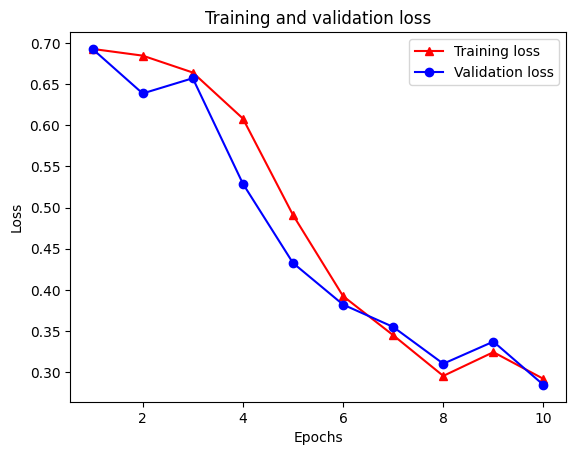

In [26]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

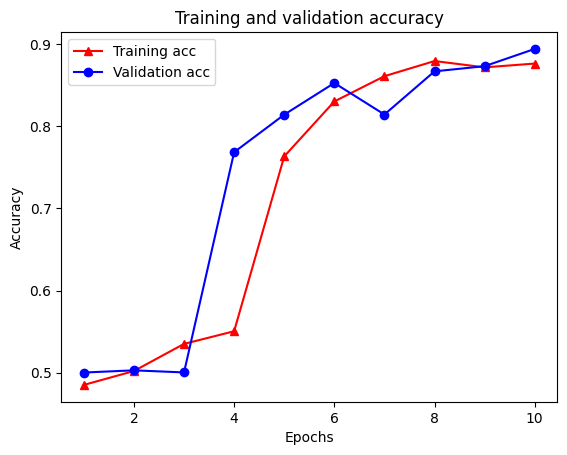

In [27]:
plt.clf()   # clear figure

plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

Notice the training loss *decreases* with each epoch and the training accuracy
*increases* with each epoch. This is expected when using a gradient descent
optimization—it should minimize the desired quantity on every iteration.

## Graph regularization

We are now ready to try graph regularization using the base model that we built
above. We will use the `GraphRegularization` wrapper class provided by the
Neural Structured Learning framework to wrap the base (bi-LSTM) model to include
graph regularization. The rest of the steps for training and evaluating the
graph-regularized model are similar to that of the base model.

### Create graph-regularized model

To assess the incremental benefit of graph regularization, we will create a new
base model instance. This is because `model` has already been trained for a few
iterations, and reusing this trained model to create a graph-regularized model
will not be a fair comparison for `model`.

In [28]:
# Build a new base LSTM model.
base_reg_model = make_bilstm_model()

In [29]:
# Wrap the base model with graph regularization.
graph_reg_config = nsl.configs.make_graph_reg_config(
    max_neighbors=HPARAMS.num_neighbors,
    multiplier=HPARAMS.graph_regularization_multiplier,
    distance_type=HPARAMS.distance_type,
    sum_over_axis=-1)
graph_reg_model = nsl.keras.GraphRegularization(base_reg_model,
                                                graph_reg_config)
graph_reg_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

### Train the model

In [30]:
graph_reg_history = graph_reg_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=HPARAMS.train_epochs,
    verbose=1)

Epoch 1/10


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


      1/Unknown - 8s 8s/step - loss: 0.6927 - accuracy: 0.4531 - scaled_graph_loss: 5.1612e-06

      2/Unknown - 8s 250ms/step - loss: 0.6933 - accuracy: 0.4766 - scaled_graph_loss: 1.1105e-05

      3/Unknown - 9s 249ms/step - loss: 0.6931 - accuracy: 0.4792 - scaled_graph_loss: 1.0886e-05

      4/Unknown - 9s 247ms/step - loss: 0.6923 - accuracy: 0.4688 - scaled_graph_loss: 1.0716e-05

      5/Unknown - 9s 247ms/step - loss: 0.6921 - accuracy: 0.4672 - scaled_graph_loss: 1.1883e-05

      6/Unknown - 9s 247ms/step - loss: 0.6920 - accuracy: 0.4688 - scaled_graph_loss: 1.4482e-05

      7/Unknown - 10s 247ms/step - loss: 0.6911 - accuracy: 0.4621 - scaled_graph_loss: 1.7061e-05

      8/Unknown - 10s 246ms/step - loss: 0.6912 - accuracy: 0.4639 - scaled_graph_loss: 2.1479e-05

      9/Unknown - 10s 246ms/step - loss: 0.6907 - accuracy: 0.4601 - scaled_graph_loss: 2.6979e-05

     10/Unknown - 10s 246ms/step - loss: 0.6903 - accuracy: 0.4578 - scaled_graph_loss: 3.2436e-05

     11/Unknown - 11s 245ms/step - loss: 0.6929 - accuracy: 0.4709 - scaled_graph_loss: 3.7401e-05

     12/Unknown - 11s 245ms/step - loss: 0.6928 - accuracy: 0.4707 - scaled_graph_loss: 4.0606e-05

     13/Unknown - 11s 245ms/step - loss: 0.6932 - accuracy: 0.4736 - scaled_graph_loss: 4.2779e-05

     14/Unknown - 11s 245ms/step - loss: 0.6929 - accuracy: 0.4721 - scaled_graph_loss: 4.3659e-05

     15/Unknown - 12s 245ms/step - loss: 0.6935 - accuracy: 0.4766 - scaled_graph_loss: 4.2799e-05

     16/Unknown - 12s 245ms/step - loss: 0.6934 - accuracy: 0.4766 - scaled_graph_loss: 4.1548e-05

     17/Unknown - 12s 245ms/step - loss: 0.6934 - accuracy: 0.4779 - scaled_graph_loss: 4.0260e-05

     18/Unknown - 12s 245ms/step - loss: 0.6938 - accuracy: 0.4835 - scaled_graph_loss: 3.8706e-05

     19/Unknown - 13s 245ms/step - loss: 0.6940 - accuracy: 0.4860 - scaled_graph_loss: 3.7059e-05

     20/Unknown - 13s 245ms/step - loss: 0.6938 - accuracy: 0.4840 - scaled_graph_loss: 3.5437e-05

     21/Unknown - 13s 240ms/step - loss: 0.6938 - accuracy: 0.4858 - scaled_graph_loss: 3.3994e-05

21/21 [==============================] - 27s 920ms/step - loss: 0.6938 - accuracy: 0.4858 - scaled_graph_loss: 3.3994e-05 - val_loss: 0.6928 - val_accuracy: 0.5024


Epoch 2/10


 1/21 [>.............................] - ETA: 13s - loss: 0.6916 - accuracy: 0.4297 - scaled_graph_loss: 5.0998e-06

 2/21 [=>............................] - ETA: 4s - loss: 0.6922 - accuracy: 0.4531 - scaled_graph_loss: 5.7828e-06 

 3/21 [===>..........................] - ETA: 4s - loss: 0.6924 - accuracy: 0.4661 - scaled_graph_loss: 6.1594e-06

 4/21 [====>.........................] - ETA: 4s - loss: 0.6924 - accuracy: 0.4746 - scaled_graph_loss: 6.6920e-06

 5/21 [======>.......................] - ETA: 3s - loss: 0.6925 - accuracy: 0.4828 - scaled_graph_loss: 6.8863e-06

 6/21 [=======>......................] - ETA: 3s - loss: 0.6924 - accuracy: 0.4883 - scaled_graph_loss: 6.9693e-06

 7/21 [=========>....................] - ETA: 3s - loss: 0.6925 - accuracy: 0.4877 - scaled_graph_loss: 7.2980e-06

 8/21 [==========>...................] - ETA: 3s - loss: 0.6923 - accuracy: 0.5020 - scaled_graph_loss: 7.3272e-06

 9/21 [===========>..................] - ETA: 2s - loss: 0.6923 - accuracy: 0.5043 - scaled_graph_loss: 7.5108e-06

10/21 [=============>................] - ETA: 2s - loss: 0.6924 - accuracy: 0.5008 - scaled_graph_loss: 8.2386e-06

11/21 [==============>...............] - ETA: 2s - loss: 0.6922 - accuracy: 0.5057 - scaled_graph_loss: 9.2088e-06

12/21 [================>.............] - ETA: 2s - loss: 0.6923 - accuracy: 0.5033 - scaled_graph_loss: 1.0066e-05

13/21 [=================>............] - ETA: 1s - loss: 0.6922 - accuracy: 0.5066 - scaled_graph_loss: 1.1193e-05

14/21 [===================>..........] - ETA: 1s - loss: 0.6922 - accuracy: 0.5061 - scaled_graph_loss: 1.2351e-05

15/21 [====================>.........] - ETA: 1s - loss: 0.6921 - accuracy: 0.5089 - scaled_graph_loss: 1.3663e-05

16/21 [=====================>........] - ETA: 1s - loss: 0.6920 - accuracy: 0.5132 - scaled_graph_loss: 1.5015e-05

17/21 [=======================>......] - ETA: 0s - loss: 0.6919 - accuracy: 0.5142 - scaled_graph_loss: 1.7004e-05

18/21 [========================>.....] - ETA: 0s - loss: 0.6920 - accuracy: 0.5135 - scaled_graph_loss: 1.8933e-05

19/21 [==========================>...] - ETA: 0s - loss: 0.6919 - accuracy: 0.5136 - scaled_graph_loss: 2.0180e-05

20/21 [===========================>..] - ETA: 0s - loss: 0.6921 - accuracy: 0.5090 - scaled_graph_loss: 2.1446e-05

21/21 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5085 - scaled_graph_loss: 2.2528e-05

21/21 [==============================] - 17s 836ms/step - loss: 0.6921 - accuracy: 0.5085 - scaled_graph_loss: 2.2528e-05 - val_loss: 0.6916 - val_accuracy: 0.4987


Epoch 3/10


 1/21 [>.............................] - ETA: 13s - loss: 0.6939 - accuracy: 0.4688 - scaled_graph_loss: 6.7862e-05

 2/21 [=>............................] - ETA: 4s - loss: 0.6917 - accuracy: 0.5039 - scaled_graph_loss: 6.9671e-05 

 3/21 [===>..........................] - ETA: 4s - loss: 0.6908 - accuracy: 0.5130 - scaled_graph_loss: 6.5640e-05

 4/21 [====>.........................] - ETA: 4s - loss: 0.6911 - accuracy: 0.4922 - scaled_graph_loss: 7.0389e-05

 5/21 [======>.......................] - ETA: 3s - loss: 0.6909 - accuracy: 0.4938 - scaled_graph_loss: 8.3080e-05

 6/21 [=======>......................] - ETA: 3s - loss: 0.6906 - accuracy: 0.4818 - scaled_graph_loss: 8.7481e-05

 7/21 [=========>....................] - ETA: 3s - loss: 0.6902 - accuracy: 0.4833 - scaled_graph_loss: 9.1410e-05

 8/21 [==========>...................] - ETA: 3s - loss: 0.6898 - accuracy: 0.4766 - scaled_graph_loss: 9.6830e-05

 9/21 [===========>..................] - ETA: 2s - loss: 0.6904 - accuracy: 0.4878 - scaled_graph_loss: 1.0697e-04

10/21 [=============>................] - ETA: 2s - loss: 0.6897 - accuracy: 0.4836 - scaled_graph_loss: 1.1932e-04

11/21 [==============>...............] - ETA: 2s - loss: 0.6900 - accuracy: 0.4901 - scaled_graph_loss: 1.4425e-04

12/21 [================>.............] - ETA: 2s - loss: 0.6894 - accuracy: 0.4915 - scaled_graph_loss: 1.8546e-04

13/21 [=================>............] - ETA: 1s - loss: 0.6881 - accuracy: 0.4892 - scaled_graph_loss: 2.6229e-04

14/21 [===================>..........] - ETA: 1s - loss: 0.6855 - accuracy: 0.4944 - scaled_graph_loss: 4.3725e-04

15/21 [====================>.........] - ETA: 1s - loss: 0.6853 - accuracy: 0.5000 - scaled_graph_loss: 0.0014    

16/21 [=====================>........] - ETA: 1s - loss: 0.6851 - accuracy: 0.5000 - scaled_graph_loss: 0.0014

17/21 [=======================>......] - ETA: 0s - loss: 0.6838 - accuracy: 0.5046 - scaled_graph_loss: 0.0014

18/21 [========================>.....] - ETA: 0s - loss: 0.6822 - accuracy: 0.5048 - scaled_graph_loss: 0.0015

19/21 [==========================>...] - ETA: 0s - loss: 0.6813 - accuracy: 0.5045 - scaled_graph_loss: 0.0015

20/21 [===========================>..] - ETA: 0s - loss: 0.6812 - accuracy: 0.5086 - scaled_graph_loss: 0.0016

21/21 [==============================] - ETA: 0s - loss: 0.6806 - accuracy: 0.5088 - scaled_graph_loss: 0.0018

21/21 [==============================] - 18s 844ms/step - loss: 0.6806 - accuracy: 0.5088 - scaled_graph_loss: 0.0018 - val_loss: 0.6383 - val_accuracy: 0.6404


Epoch 4/10


 1/21 [>.............................] - ETA: 13s - loss: 0.6580 - accuracy: 0.6250 - scaled_graph_loss: 0.0061

 2/21 [=>............................] - ETA: 4s - loss: 0.6594 - accuracy: 0.6484 - scaled_graph_loss: 0.0206 

 3/21 [===>..........................] - ETA: 4s - loss: 0.6519 - accuracy: 0.6016 - scaled_graph_loss: 0.0164

 4/21 [====>.........................] - ETA: 4s - loss: 0.6492 - accuracy: 0.5840 - scaled_graph_loss: 0.0137

 5/21 [======>.......................] - ETA: 3s - loss: 0.6487 - accuracy: 0.5750 - scaled_graph_loss: 0.0121

 6/21 [=======>......................] - ETA: 3s - loss: 0.6504 - accuracy: 0.5664 - scaled_graph_loss: 0.0110

 7/21 [=========>....................] - ETA: 3s - loss: 0.6484 - accuracy: 0.5670 - scaled_graph_loss: 0.0103

 8/21 [==========>...................] - ETA: 3s - loss: 0.6449 - accuracy: 0.5693 - scaled_graph_loss: 0.0102

 9/21 [===========>..................] - ETA: 2s - loss: 0.6418 - accuracy: 0.5799 - scaled_graph_loss: 0.0109

10/21 [=============>................] - ETA: 2s - loss: 0.6420 - accuracy: 0.5914 - scaled_graph_loss: 0.0132

11/21 [==============>...............] - ETA: 2s - loss: 0.6369 - accuracy: 0.6094 - scaled_graph_loss: 0.0153

12/21 [================>.............] - ETA: 2s - loss: 0.6330 - accuracy: 0.6159 - scaled_graph_loss: 0.0173

13/21 [=================>............] - ETA: 1s - loss: 0.6288 - accuracy: 0.6262 - scaled_graph_loss: 0.0216

14/21 [===================>..........] - ETA: 1s - loss: 0.6249 - accuracy: 0.6295 - scaled_graph_loss: 0.0220

15/21 [====================>.........] - ETA: 1s - loss: 0.6229 - accuracy: 0.6276 - scaled_graph_loss: 0.0237

16/21 [=====================>........] - ETA: 1s - loss: 0.6193 - accuracy: 0.6392 - scaled_graph_loss: 0.0283

17/21 [=======================>......] - ETA: 0s - loss: 0.6175 - accuracy: 0.6517 - scaled_graph_loss: 0.0300

18/21 [========================>.....] - ETA: 0s - loss: 0.6172 - accuracy: 0.6576 - scaled_graph_loss: 0.0307

19/21 [==========================>...] - ETA: 0s - loss: 0.6156 - accuracy: 0.6567 - scaled_graph_loss: 0.0305

20/21 [===========================>..] - ETA: 0s - loss: 0.6143 - accuracy: 0.6598 - scaled_graph_loss: 0.0300

21/21 [==============================] - ETA: 0s - loss: 0.6143 - accuracy: 0.6588 - scaled_graph_loss: 0.0292

21/21 [==============================] - 17s 837ms/step - loss: 0.6143 - accuracy: 0.6588 - scaled_graph_loss: 0.0292 - val_loss: 0.5993 - val_accuracy: 0.5436


Epoch 5/10


 1/21 [>.............................] - ETA: 13s - loss: 0.6245 - accuracy: 0.4688 - scaled_graph_loss: 0.0160

 2/21 [=>............................] - ETA: 4s - loss: 0.6162 - accuracy: 0.5117 - scaled_graph_loss: 0.0165 

 3/21 [===>..........................] - ETA: 4s - loss: 0.6063 - accuracy: 0.5443 - scaled_graph_loss: 0.0188

 4/21 [====>.........................] - ETA: 4s - loss: 0.6077 - accuracy: 0.5566 - scaled_graph_loss: 0.0203

 5/21 [======>.......................] - ETA: 3s - loss: 0.5940 - accuracy: 0.5813 - scaled_graph_loss: 0.0227

 6/21 [=======>......................] - ETA: 3s - loss: 0.5893 - accuracy: 0.6029 - scaled_graph_loss: 0.0271

 7/21 [=========>....................] - ETA: 3s - loss: 0.5848 - accuracy: 0.6317 - scaled_graph_loss: 0.0318

 8/21 [==========>...................] - ETA: 3s - loss: 0.5861 - accuracy: 0.6553 - scaled_graph_loss: 0.0394

 9/21 [===========>..................] - ETA: 2s - loss: 0.5887 - accuracy: 0.6623 - scaled_graph_loss: 0.0448

10/21 [=============>................] - ETA: 2s - loss: 0.5856 - accuracy: 0.6766 - scaled_graph_loss: 0.0503

11/21 [==============>...............] - ETA: 2s - loss: 0.5836 - accuracy: 0.6847 - scaled_graph_loss: 0.0533

12/21 [================>.............] - ETA: 2s - loss: 0.5806 - accuracy: 0.6914 - scaled_graph_loss: 0.0544

13/21 [=================>............] - ETA: 1s - loss: 0.5787 - accuracy: 0.6941 - scaled_graph_loss: 0.0549

14/21 [===================>..........] - ETA: 1s - loss: 0.5804 - accuracy: 0.6903 - scaled_graph_loss: 0.0550

15/21 [====================>.........] - ETA: 1s - loss: 0.5784 - accuracy: 0.6906 - scaled_graph_loss: 0.0538

16/21 [=====================>........] - ETA: 1s - loss: 0.5786 - accuracy: 0.6875 - scaled_graph_loss: 0.0528

17/21 [=======================>......] - ETA: 0s - loss: 0.5803 - accuracy: 0.6838 - scaled_graph_loss: 0.0523

18/21 [========================>.....] - ETA: 0s - loss: 0.5790 - accuracy: 0.6871 - scaled_graph_loss: 0.0522

19/21 [==========================>...] - ETA: 0s - loss: 0.5760 - accuracy: 0.6924 - scaled_graph_loss: 0.0523

20/21 [===========================>..] - ETA: 0s - loss: 0.5742 - accuracy: 0.7004 - scaled_graph_loss: 0.0534

21/21 [==============================] - ETA: 0s - loss: 0.5748 - accuracy: 0.7015 - scaled_graph_loss: 0.0563

21/21 [==============================] - 17s 841ms/step - loss: 0.5748 - accuracy: 0.7015 - scaled_graph_loss: 0.0563 - val_loss: 0.4726 - val_accuracy: 0.8239


Epoch 6/10


 1/21 [>.............................] - ETA: 13s - loss: 0.5438 - accuracy: 0.8125 - scaled_graph_loss: 0.0886

 2/21 [=>............................] - ETA: 4s - loss: 0.5423 - accuracy: 0.8125 - scaled_graph_loss: 0.0768 

 3/21 [===>..........................] - ETA: 4s - loss: 0.5380 - accuracy: 0.8151 - scaled_graph_loss: 0.0687

 4/21 [====>.........................] - ETA: 4s - loss: 0.5440 - accuracy: 0.7949 - scaled_graph_loss: 0.0649

 5/21 [======>.......................] - ETA: 3s - loss: 0.5458 - accuracy: 0.7875 - scaled_graph_loss: 0.0608

 6/21 [=======>......................] - ETA: 3s - loss: 0.5449 - accuracy: 0.7852 - scaled_graph_loss: 0.0587

 7/21 [=========>....................] - ETA: 3s - loss: 0.5423 - accuracy: 0.7868 - scaled_graph_loss: 0.0558

 8/21 [==========>...................] - ETA: 3s - loss: 0.5401 - accuracy: 0.7900 - scaled_graph_loss: 0.0568

 9/21 [===========>..................] - ETA: 2s - loss: 0.5402 - accuracy: 0.7856 - scaled_graph_loss: 0.0560

10/21 [=============>................] - ETA: 2s - loss: 0.5367 - accuracy: 0.7883 - scaled_graph_loss: 0.0556

11/21 [==============>...............] - ETA: 2s - loss: 0.5394 - accuracy: 0.7891 - scaled_graph_loss: 0.0608

12/21 [================>.............] - ETA: 2s - loss: 0.5398 - accuracy: 0.7897 - scaled_graph_loss: 0.0653

13/21 [=================>............] - ETA: 1s - loss: 0.5407 - accuracy: 0.7921 - scaled_graph_loss: 0.0683

14/21 [===================>..........] - ETA: 1s - loss: 0.5393 - accuracy: 0.7935 - scaled_graph_loss: 0.0696

15/21 [====================>.........] - ETA: 1s - loss: 0.5359 - accuracy: 0.8000 - scaled_graph_loss: 0.0691

16/21 [=====================>........] - ETA: 1s - loss: 0.5360 - accuracy: 0.8032 - scaled_graph_loss: 0.0687

17/21 [=======================>......] - ETA: 0s - loss: 0.5395 - accuracy: 0.8051 - scaled_graph_loss: 0.0699

18/21 [========================>.....] - ETA: 0s - loss: 0.5376 - accuracy: 0.8064 - scaled_graph_loss: 0.0691

19/21 [==========================>...] - ETA: 0s - loss: 0.5370 - accuracy: 0.8030 - scaled_graph_loss: 0.0685

20/21 [===========================>..] - ETA: 0s - loss: 0.5361 - accuracy: 0.8031 - scaled_graph_loss: 0.0681

21/21 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.8019 - scaled_graph_loss: 0.0681

21/21 [==============================] - 18s 847ms/step - loss: 0.5366 - accuracy: 0.8019 - scaled_graph_loss: 0.0681 - val_loss: 0.4708 - val_accuracy: 0.7508


Epoch 7/10


 1/21 [>.............................] - ETA: 13s - loss: 0.6271 - accuracy: 0.6484 - scaled_graph_loss: 0.0846

 2/21 [=>............................] - ETA: 4s - loss: 0.5767 - accuracy: 0.7578 - scaled_graph_loss: 0.0782 

 3/21 [===>..........................] - ETA: 4s - loss: 0.5741 - accuracy: 0.7708 - scaled_graph_loss: 0.0708

 4/21 [====>.........................] - ETA: 4s - loss: 0.5616 - accuracy: 0.8008 - scaled_graph_loss: 0.0686

 5/21 [======>.......................] - ETA: 3s - loss: 0.5566 - accuracy: 0.8000 - scaled_graph_loss: 0.0660

 6/21 [=======>......................] - ETA: 3s - loss: 0.5546 - accuracy: 0.8060 - scaled_graph_loss: 0.0661

 7/21 [=========>....................] - ETA: 3s - loss: 0.5541 - accuracy: 0.8047 - scaled_graph_loss: 0.0657

 8/21 [==========>...................] - ETA: 3s - loss: 0.5503 - accuracy: 0.8076 - scaled_graph_loss: 0.0662

 9/21 [===========>..................] - ETA: 2s - loss: 0.5475 - accuracy: 0.8073 - scaled_graph_loss: 0.0691

10/21 [=============>................] - ETA: 2s - loss: 0.5463 - accuracy: 0.8086 - scaled_graph_loss: 0.0712

11/21 [==============>...............] - ETA: 2s - loss: 0.5415 - accuracy: 0.8061 - scaled_graph_loss: 0.0716

12/21 [================>.............] - ETA: 2s - loss: 0.5403 - accuracy: 0.8047 - scaled_graph_loss: 0.0719

13/21 [=================>............] - ETA: 1s - loss: 0.5349 - accuracy: 0.8137 - scaled_graph_loss: 0.0746

14/21 [===================>..........] - ETA: 1s - loss: 0.5331 - accuracy: 0.8181 - scaled_graph_loss: 0.0759

15/21 [====================>.........] - ETA: 1s - loss: 0.5309 - accuracy: 0.8214 - scaled_graph_loss: 0.0759

16/21 [=====================>........] - ETA: 1s - loss: 0.5304 - accuracy: 0.8193 - scaled_graph_loss: 0.0756

17/21 [=======================>......] - ETA: 0s - loss: 0.5323 - accuracy: 0.8120 - scaled_graph_loss: 0.0752

18/21 [========================>.....] - ETA: 0s - loss: 0.5325 - accuracy: 0.8069 - scaled_graph_loss: 0.0743

19/21 [==========================>...] - ETA: 0s - loss: 0.5333 - accuracy: 0.8006 - scaled_graph_loss: 0.0728

20/21 [===========================>..] - ETA: 0s - loss: 0.5329 - accuracy: 0.7992 - scaled_graph_loss: 0.0726

21/21 [==============================] - ETA: 0s - loss: 0.5330 - accuracy: 0.7992 - scaled_graph_loss: 0.0722

21/21 [==============================] - 18s 847ms/step - loss: 0.5330 - accuracy: 0.7992 - scaled_graph_loss: 0.0722 - val_loss: 0.4462 - val_accuracy: 0.8373


Epoch 8/10


 1/21 [>.............................] - ETA: 13s - loss: 0.4604 - accuracy: 0.8828 - scaled_graph_loss: 0.0559

 2/21 [=>............................] - ETA: 4s - loss: 0.4958 - accuracy: 0.8633 - scaled_graph_loss: 0.0770 

 3/21 [===>..........................] - ETA: 4s - loss: 0.4957 - accuracy: 0.8698 - scaled_graph_loss: 0.0795

 4/21 [====>.........................] - ETA: 4s - loss: 0.5153 - accuracy: 0.8750 - scaled_graph_loss: 0.0885

 5/21 [======>.......................] - ETA: 3s - loss: 0.5189 - accuracy: 0.8594 - scaled_graph_loss: 0.0875

 6/21 [=======>......................] - ETA: 3s - loss: 0.5174 - accuracy: 0.8438 - scaled_graph_loss: 0.0835

 7/21 [=========>....................] - ETA: 3s - loss: 0.5197 - accuracy: 0.8270 - scaled_graph_loss: 0.0809

 8/21 [==========>...................] - ETA: 3s - loss: 0.5209 - accuracy: 0.8193 - scaled_graph_loss: 0.0789

 9/21 [===========>..................] - ETA: 2s - loss: 0.5205 - accuracy: 0.8194 - scaled_graph_loss: 0.0762

10/21 [=============>................] - ETA: 2s - loss: 0.5208 - accuracy: 0.8148 - scaled_graph_loss: 0.0750

11/21 [==============>...............] - ETA: 2s - loss: 0.5217 - accuracy: 0.8139 - scaled_graph_loss: 0.0737

12/21 [================>.............] - ETA: 2s - loss: 0.5201 - accuracy: 0.8177 - scaled_graph_loss: 0.0735

13/21 [=================>............] - ETA: 1s - loss: 0.5189 - accuracy: 0.8221 - scaled_graph_loss: 0.0739

14/21 [===================>..........] - ETA: 1s - loss: 0.5153 - accuracy: 0.8276 - scaled_graph_loss: 0.0761

15/21 [====================>.........] - ETA: 1s - loss: 0.5168 - accuracy: 0.8266 - scaled_graph_loss: 0.0807

16/21 [=====================>........] - ETA: 1s - loss: 0.5185 - accuracy: 0.8247 - scaled_graph_loss: 0.0825

17/21 [=======================>......] - ETA: 0s - loss: 0.5210 - accuracy: 0.8222 - scaled_graph_loss: 0.0822

18/21 [========================>.....] - ETA: 0s - loss: 0.5204 - accuracy: 0.8190 - scaled_graph_loss: 0.0808

19/21 [==========================>...] - ETA: 0s - loss: 0.5203 - accuracy: 0.8125 - scaled_graph_loss: 0.0792

20/21 [===========================>..] - ETA: 0s - loss: 0.5216 - accuracy: 0.8082 - scaled_graph_loss: 0.0771

21/21 [==============================] - ETA: 0s - loss: 0.5207 - accuracy: 0.8096 - scaled_graph_loss: 0.0755

21/21 [==============================] - 18s 848ms/step - loss: 0.5207 - accuracy: 0.8096 - scaled_graph_loss: 0.0755 - val_loss: 0.4772 - val_accuracy: 0.7738


Epoch 9/10


 1/21 [>.............................] - ETA: 13s - loss: 0.5184 - accuracy: 0.7891 - scaled_graph_loss: 0.0546

 2/21 [=>............................] - ETA: 4s - loss: 0.5125 - accuracy: 0.8164 - scaled_graph_loss: 0.0598 

 3/21 [===>..........................] - ETA: 4s - loss: 0.5249 - accuracy: 0.8203 - scaled_graph_loss: 0.0671

 4/21 [====>.........................] - ETA: 4s - loss: 0.5309 - accuracy: 0.8125 - scaled_graph_loss: 0.0725

 5/21 [======>.......................] - ETA: 3s - loss: 0.5361 - accuracy: 0.8078 - scaled_graph_loss: 0.0786

 6/21 [=======>......................] - ETA: 3s - loss: 0.5318 - accuracy: 0.8125 - scaled_graph_loss: 0.0796

 7/21 [=========>....................] - ETA: 3s - loss: 0.5300 - accuracy: 0.8203 - scaled_graph_loss: 0.0810

 8/21 [==========>...................] - ETA: 3s - loss: 0.5295 - accuracy: 0.8203 - scaled_graph_loss: 0.0792

 9/21 [===========>..................] - ETA: 2s - loss: 0.5293 - accuracy: 0.8151 - scaled_graph_loss: 0.0772

10/21 [=============>................] - ETA: 2s - loss: 0.5237 - accuracy: 0.8156 - scaled_graph_loss: 0.0763

11/21 [==============>...............] - ETA: 2s - loss: 0.5230 - accuracy: 0.8168 - scaled_graph_loss: 0.0770

12/21 [================>.............] - ETA: 2s - loss: 0.5203 - accuracy: 0.8190 - scaled_graph_loss: 0.0769

13/21 [=================>............] - ETA: 1s - loss: 0.5193 - accuracy: 0.8221 - scaled_graph_loss: 0.0784

14/21 [===================>..........] - ETA: 1s - loss: 0.5216 - accuracy: 0.8214 - scaled_graph_loss: 0.0813

15/21 [====================>.........] - ETA: 1s - loss: 0.5185 - accuracy: 0.8240 - scaled_graph_loss: 0.0819

16/21 [=====================>........] - ETA: 1s - loss: 0.5191 - accuracy: 0.8232 - scaled_graph_loss: 0.0831

17/21 [=======================>......] - ETA: 0s - loss: 0.5168 - accuracy: 0.8267 - scaled_graph_loss: 0.0831

18/21 [========================>.....] - ETA: 0s - loss: 0.5150 - accuracy: 0.8281 - scaled_graph_loss: 0.0821

19/21 [==========================>...] - ETA: 0s - loss: 0.5138 - accuracy: 0.8306 - scaled_graph_loss: 0.0821

20/21 [===========================>..] - ETA: 0s - loss: 0.5141 - accuracy: 0.8313 - scaled_graph_loss: 0.0823

21/21 [==============================] - ETA: 0s - loss: 0.5139 - accuracy: 0.8319 - scaled_graph_loss: 0.0831

21/21 [==============================] - 18s 851ms/step - loss: 0.5139 - accuracy: 0.8319 - scaled_graph_loss: 0.0831 - val_loss: 0.4223 - val_accuracy: 0.8412


Epoch 10/10


 1/21 [>.............................] - ETA: 13s - loss: 0.5168 - accuracy: 0.8359 - scaled_graph_loss: 0.0857

 2/21 [=>............................] - ETA: 4s - loss: 0.4873 - accuracy: 0.8477 - scaled_graph_loss: 0.0751 

 3/21 [===>..........................] - ETA: 4s - loss: 0.4875 - accuracy: 0.8438 - scaled_graph_loss: 0.0755

 4/21 [====>.........................] - ETA: 4s - loss: 0.5037 - accuracy: 0.8262 - scaled_graph_loss: 0.0799

 5/21 [======>.......................] - ETA: 3s - loss: 0.5011 - accuracy: 0.8422 - scaled_graph_loss: 0.0834

 6/21 [=======>......................] - ETA: 3s - loss: 0.5057 - accuracy: 0.8451 - scaled_graph_loss: 0.0852

 7/21 [=========>....................] - ETA: 3s - loss: 0.4996 - accuracy: 0.8493 - scaled_graph_loss: 0.0830

 8/21 [==========>...................] - ETA: 3s - loss: 0.4992 - accuracy: 0.8477 - scaled_graph_loss: 0.0828

 9/21 [===========>..................] - ETA: 2s - loss: 0.4996 - accuracy: 0.8446 - scaled_graph_loss: 0.0815

10/21 [=============>................] - ETA: 2s - loss: 0.4995 - accuracy: 0.8445 - scaled_graph_loss: 0.0820

11/21 [==============>...............] - ETA: 2s - loss: 0.4988 - accuracy: 0.8402 - scaled_graph_loss: 0.0805

12/21 [================>.............] - ETA: 2s - loss: 0.4974 - accuracy: 0.8379 - scaled_graph_loss: 0.0812

13/21 [=================>............] - ETA: 1s - loss: 0.4959 - accuracy: 0.8407 - scaled_graph_loss: 0.0819

14/21 [===================>..........] - ETA: 1s - loss: 0.4971 - accuracy: 0.8387 - scaled_graph_loss: 0.0822

15/21 [====================>.........] - ETA: 1s - loss: 0.4975 - accuracy: 0.8401 - scaled_graph_loss: 0.0830

16/21 [=====================>........] - ETA: 1s - loss: 0.4954 - accuracy: 0.8447 - scaled_graph_loss: 0.0837

17/21 [=======================>......] - ETA: 0s - loss: 0.4942 - accuracy: 0.8470 - scaled_graph_loss: 0.0831

18/21 [========================>.....] - ETA: 0s - loss: 0.4943 - accuracy: 0.8433 - scaled_graph_loss: 0.0818

19/21 [==========================>...] - ETA: 0s - loss: 0.4965 - accuracy: 0.8388 - scaled_graph_loss: 0.0825

20/21 [===========================>..] - ETA: 0s - loss: 0.4960 - accuracy: 0.8391 - scaled_graph_loss: 0.0820

21/21 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.8377 - scaled_graph_loss: 0.0813

21/21 [==============================] - 18s 851ms/step - loss: 0.4959 - accuracy: 0.8377 - scaled_graph_loss: 0.0813 - val_loss: 0.4332 - val_accuracy: 0.8199


### Evaluate the model

In [31]:
graph_reg_results = graph_reg_model.evaluate(test_dataset, steps=HPARAMS.eval_steps)
print(graph_reg_results)

      1/Unknown - 1s 808ms/step - loss: 0.4703 - accuracy: 0.7656

      2/Unknown - 1s 71ms/step - loss: 0.4792 - accuracy: 0.7539 

      3/Unknown - 1s 69ms/step - loss: 0.4834 - accuracy: 0.7500

      4/Unknown - 1s 70ms/step - loss: 0.4901 - accuracy: 0.7383

      5/Unknown - 1s 70ms/step - loss: 0.4918 - accuracy: 0.7422

      6/Unknown - 1s 70ms/step - loss: 0.4851 - accuracy: 0.7513

      7/Unknown - 1s 70ms/step - loss: 0.4799 - accuracy: 0.7589

      8/Unknown - 1s 70ms/step - loss: 0.4827 - accuracy: 0.7627

      9/Unknown - 1s 70ms/step - loss: 0.4783 - accuracy: 0.7708

     10/Unknown - 1s 71ms/step - loss: 0.4819 - accuracy: 0.7672

     11/Unknown - 2s 71ms/step - loss: 0.4813 - accuracy: 0.7649

     12/Unknown - 2s 71ms/step - loss: 0.4739 - accuracy: 0.7754

     13/Unknown - 2s 71ms/step - loss: 0.4748 - accuracy: 0.7752

     14/Unknown - 2s 71ms/step - loss: 0.4754 - accuracy: 0.7757

     15/Unknown - 2s 71ms/step - loss: 0.4747 - accuracy: 0.7760

     16/Unknown - 2s 71ms/step - loss: 0.4754 - accuracy: 0.7739

     17/Unknown - 2s 71ms/step - loss: 0.4756 - accuracy: 0.7757

     18/Unknown - 2s 71ms/step - loss: 0.4746 - accuracy: 0.7756

     19/Unknown - 2s 71ms/step - loss: 0.4747 - accuracy: 0.7763

     20/Unknown - 2s 71ms/step - loss: 0.4755 - accuracy: 0.7738

     21/Unknown - 2s 71ms/step - loss: 0.4758 - accuracy: 0.7727

     22/Unknown - 2s 71ms/step - loss: 0.4758 - accuracy: 0.7727

     23/Unknown - 2s 71ms/step - loss: 0.4751 - accuracy: 0.7755

     24/Unknown - 2s 71ms/step - loss: 0.4737 - accuracy: 0.7770

     25/Unknown - 3s 71ms/step - loss: 0.4740 - accuracy: 0.7775

     26/Unknown - 3s 71ms/step - loss: 0.4730 - accuracy: 0.7785

     27/Unknown - 3s 71ms/step - loss: 0.4726 - accuracy: 0.7798

     28/Unknown - 3s 71ms/step - loss: 0.4739 - accuracy: 0.7787

     29/Unknown - 3s 71ms/step - loss: 0.4741 - accuracy: 0.7786

     30/Unknown - 3s 71ms/step - loss: 0.4741 - accuracy: 0.7771

     31/Unknown - 3s 71ms/step - loss: 0.4751 - accuracy: 0.7770

     32/Unknown - 3s 71ms/step - loss: 0.4750 - accuracy: 0.7761

     33/Unknown - 3s 71ms/step - loss: 0.4749 - accuracy: 0.7772

     34/Unknown - 3s 71ms/step - loss: 0.4742 - accuracy: 0.7776

     35/Unknown - 3s 71ms/step - loss: 0.4734 - accuracy: 0.7772

     36/Unknown - 3s 71ms/step - loss: 0.4722 - accuracy: 0.7789

     37/Unknown - 3s 71ms/step - loss: 0.4723 - accuracy: 0.7785

     38/Unknown - 3s 71ms/step - loss: 0.4727 - accuracy: 0.7775

     39/Unknown - 4s 71ms/step - loss: 0.4728 - accuracy: 0.7778

     40/Unknown - 4s 71ms/step - loss: 0.4730 - accuracy: 0.7773

     41/Unknown - 4s 71ms/step - loss: 0.4735 - accuracy: 0.7759

     42/Unknown - 4s 71ms/step - loss: 0.4728 - accuracy: 0.7762

     43/Unknown - 4s 71ms/step - loss: 0.4733 - accuracy: 0.7754

     44/Unknown - 4s 71ms/step - loss: 0.4738 - accuracy: 0.7749

     45/Unknown - 4s 71ms/step - loss: 0.4736 - accuracy: 0.7753

     46/Unknown - 4s 71ms/step - loss: 0.4736 - accuracy: 0.7756

     47/Unknown - 4s 71ms/step - loss: 0.4744 - accuracy: 0.7746

     48/Unknown - 4s 71ms/step - loss: 0.4749 - accuracy: 0.7756

     49/Unknown - 4s 71ms/step - loss: 0.4748 - accuracy: 0.7757

     50/Unknown - 4s 71ms/step - loss: 0.4749 - accuracy: 0.7761

     51/Unknown - 4s 71ms/step - loss: 0.4743 - accuracy: 0.7765

     52/Unknown - 4s 71ms/step - loss: 0.4741 - accuracy: 0.7763

     53/Unknown - 4s 71ms/step - loss: 0.4743 - accuracy: 0.7764

     54/Unknown - 5s 71ms/step - loss: 0.4748 - accuracy: 0.7752

     55/Unknown - 5s 71ms/step - loss: 0.4740 - accuracy: 0.7766

     56/Unknown - 5s 71ms/step - loss: 0.4745 - accuracy: 0.7751

     57/Unknown - 5s 71ms/step - loss: 0.4747 - accuracy: 0.7745

     58/Unknown - 5s 71ms/step - loss: 0.4742 - accuracy: 0.7744

     59/Unknown - 5s 71ms/step - loss: 0.4745 - accuracy: 0.7729

     60/Unknown - 5s 71ms/step - loss: 0.4746 - accuracy: 0.7734

     61/Unknown - 5s 71ms/step - loss: 0.4741 - accuracy: 0.7742

     62/Unknown - 5s 71ms/step - loss: 0.4741 - accuracy: 0.7742

     63/Unknown - 5s 71ms/step - loss: 0.4738 - accuracy: 0.7738

     64/Unknown - 5s 71ms/step - loss: 0.4734 - accuracy: 0.7745

     65/Unknown - 5s 71ms/step - loss: 0.4737 - accuracy: 0.7740

     66/Unknown - 5s 71ms/step - loss: 0.4738 - accuracy: 0.7736

     67/Unknown - 5s 71ms/step - loss: 0.4738 - accuracy: 0.7741

     68/Unknown - 6s 71ms/step - loss: 0.4740 - accuracy: 0.7731

     69/Unknown - 6s 71ms/step - loss: 0.4739 - accuracy: 0.7729

     70/Unknown - 6s 70ms/step - loss: 0.4738 - accuracy: 0.7724

     71/Unknown - 6s 70ms/step - loss: 0.4732 - accuracy: 0.7728

     72/Unknown - 6s 70ms/step - loss: 0.4734 - accuracy: 0.7725

     73/Unknown - 6s 70ms/step - loss: 0.4739 - accuracy: 0.7720

     74/Unknown - 6s 70ms/step - loss: 0.4746 - accuracy: 0.7710

     75/Unknown - 6s 70ms/step - loss: 0.4741 - accuracy: 0.7713

     76/Unknown - 6s 70ms/step - loss: 0.4744 - accuracy: 0.7705

     77/Unknown - 6s 70ms/step - loss: 0.4747 - accuracy: 0.7700

     78/Unknown - 6s 70ms/step - loss: 0.4749 - accuracy: 0.7700

     79/Unknown - 6s 70ms/step - loss: 0.4752 - accuracy: 0.7699

     80/Unknown - 6s 70ms/step - loss: 0.4756 - accuracy: 0.7696

     81/Unknown - 6s 70ms/step - loss: 0.4760 - accuracy: 0.7690

     82/Unknown - 7s 70ms/step - loss: 0.4762 - accuracy: 0.7695

     83/Unknown - 7s 70ms/step - loss: 0.4763 - accuracy: 0.7695

     84/Unknown - 7s 70ms/step - loss: 0.4763 - accuracy: 0.7697

     85/Unknown - 7s 70ms/step - loss: 0.4763 - accuracy: 0.7697

     86/Unknown - 7s 70ms/step - loss: 0.4759 - accuracy: 0.7700

     87/Unknown - 7s 70ms/step - loss: 0.4759 - accuracy: 0.7701

     88/Unknown - 7s 70ms/step - loss: 0.4762 - accuracy: 0.7694

     89/Unknown - 7s 70ms/step - loss: 0.4763 - accuracy: 0.7689

     90/Unknown - 7s 70ms/step - loss: 0.4767 - accuracy: 0.7681

     91/Unknown - 7s 70ms/step - loss: 0.4764 - accuracy: 0.7685

     92/Unknown - 7s 70ms/step - loss: 0.4762 - accuracy: 0.7690

     93/Unknown - 7s 70ms/step - loss: 0.4762 - accuracy: 0.7695

     94/Unknown - 7s 70ms/step - loss: 0.4760 - accuracy: 0.7699

     95/Unknown - 7s 70ms/step - loss: 0.4756 - accuracy: 0.7704

     96/Unknown - 7s 70ms/step - loss: 0.4752 - accuracy: 0.7712

     97/Unknown - 8s 70ms/step - loss: 0.4757 - accuracy: 0.7708

     98/Unknown - 8s 70ms/step - loss: 0.4756 - accuracy: 0.7709

     99/Unknown - 8s 70ms/step - loss: 0.4761 - accuracy: 0.7703

    100/Unknown - 8s 70ms/step - loss: 0.4759 - accuracy: 0.7705

    101/Unknown - 8s 70ms/step - loss: 0.4757 - accuracy: 0.7706

    102/Unknown - 8s 70ms/step - loss: 0.4756 - accuracy: 0.7711

    103/Unknown - 8s 70ms/step - loss: 0.4756 - accuracy: 0.7710

    104/Unknown - 8s 70ms/step - loss: 0.4760 - accuracy: 0.7705

    105/Unknown - 8s 71ms/step - loss: 0.4753 - accuracy: 0.7714

    106/Unknown - 8s 70ms/step - loss: 0.4754 - accuracy: 0.7714

    107/Unknown - 8s 70ms/step - loss: 0.4753 - accuracy: 0.7713

    108/Unknown - 8s 70ms/step - loss: 0.4751 - accuracy: 0.7718

    109/Unknown - 8s 70ms/step - loss: 0.4750 - accuracy: 0.7721

    110/Unknown - 8s 70ms/step - loss: 0.4751 - accuracy: 0.7722

    111/Unknown - 9s 70ms/step - loss: 0.4749 - accuracy: 0.7724

    112/Unknown - 9s 70ms/step - loss: 0.4753 - accuracy: 0.7723

    113/Unknown - 9s 70ms/step - loss: 0.4752 - accuracy: 0.7724

    114/Unknown - 9s 70ms/step - loss: 0.4753 - accuracy: 0.7723

    115/Unknown - 9s 70ms/step - loss: 0.4752 - accuracy: 0.7724

    116/Unknown - 9s 70ms/step - loss: 0.4750 - accuracy: 0.7728

    117/Unknown - 9s 70ms/step - loss: 0.4751 - accuracy: 0.7726

    118/Unknown - 9s 70ms/step - loss: 0.4748 - accuracy: 0.7727

    119/Unknown - 9s 70ms/step - loss: 0.4748 - accuracy: 0.7730

    120/Unknown - 9s 70ms/step - loss: 0.4749 - accuracy: 0.7729

    121/Unknown - 9s 70ms/step - loss: 0.4749 - accuracy: 0.7729

    122/Unknown - 9s 70ms/step - loss: 0.4748 - accuracy: 0.7731

    123/Unknown - 9s 70ms/step - loss: 0.4747 - accuracy: 0.7733

    124/Unknown - 9s 70ms/step - loss: 0.4748 - accuracy: 0.7732

    125/Unknown - 10s 70ms/step - loss: 0.4749 - accuracy: 0.7732

    126/Unknown - 10s 70ms/step - loss: 0.4753 - accuracy: 0.7731

    127/Unknown - 10s 70ms/step - loss: 0.4753 - accuracy: 0.7733

    128/Unknown - 10s 70ms/step - loss: 0.4753 - accuracy: 0.7734

    129/Unknown - 10s 70ms/step - loss: 0.4753 - accuracy: 0.7733

    130/Unknown - 10s 70ms/step - loss: 0.4754 - accuracy: 0.7731

    131/Unknown - 10s 70ms/step - loss: 0.4752 - accuracy: 0.7731

    132/Unknown - 10s 70ms/step - loss: 0.4746 - accuracy: 0.7738

    133/Unknown - 10s 70ms/step - loss: 0.4747 - accuracy: 0.7735

    134/Unknown - 10s 70ms/step - loss: 0.4747 - accuracy: 0.7732

    135/Unknown - 10s 70ms/step - loss: 0.4746 - accuracy: 0.7733

    136/Unknown - 10s 70ms/step - loss: 0.4742 - accuracy: 0.7734

    137/Unknown - 10s 70ms/step - loss: 0.4739 - accuracy: 0.7736

    138/Unknown - 10s 70ms/step - loss: 0.4740 - accuracy: 0.7736

    139/Unknown - 11s 70ms/step - loss: 0.4740 - accuracy: 0.7738

    140/Unknown - 11s 70ms/step - loss: 0.4741 - accuracy: 0.7737

    141/Unknown - 11s 70ms/step - loss: 0.4741 - accuracy: 0.7732

    142/Unknown - 11s 70ms/step - loss: 0.4739 - accuracy: 0.7734

    143/Unknown - 11s 70ms/step - loss: 0.4736 - accuracy: 0.7739

    144/Unknown - 11s 70ms/step - loss: 0.4735 - accuracy: 0.7741

    145/Unknown - 11s 70ms/step - loss: 0.4735 - accuracy: 0.7739

    146/Unknown - 11s 70ms/step - loss: 0.4735 - accuracy: 0.7743

    147/Unknown - 11s 70ms/step - loss: 0.4734 - accuracy: 0.7741

    148/Unknown - 11s 70ms/step - loss: 0.4733 - accuracy: 0.7742

    149/Unknown - 11s 70ms/step - loss: 0.4731 - accuracy: 0.7743

    150/Unknown - 11s 70ms/step - loss: 0.4730 - accuracy: 0.7743

    151/Unknown - 11s 70ms/step - loss: 0.4729 - accuracy: 0.7744

    152/Unknown - 11s 70ms/step - loss: 0.4729 - accuracy: 0.7742

    153/Unknown - 12s 70ms/step - loss: 0.4729 - accuracy: 0.7742

    154/Unknown - 12s 70ms/step - loss: 0.4728 - accuracy: 0.7745

    155/Unknown - 12s 70ms/step - loss: 0.4730 - accuracy: 0.7740

    156/Unknown - 12s 70ms/step - loss: 0.4728 - accuracy: 0.7739

    157/Unknown - 12s 70ms/step - loss: 0.4728 - accuracy: 0.7739

    158/Unknown - 12s 70ms/step - loss: 0.4731 - accuracy: 0.7738

    159/Unknown - 12s 70ms/step - loss: 0.4733 - accuracy: 0.7736

    160/Unknown - 12s 70ms/step - loss: 0.4733 - accuracy: 0.7735

    161/Unknown - 12s 70ms/step - loss: 0.4733 - accuracy: 0.7732

    162/Unknown - 12s 70ms/step - loss: 0.4731 - accuracy: 0.7736

    163/Unknown - 12s 70ms/step - loss: 0.4734 - accuracy: 0.7734

    164/Unknown - 12s 70ms/step - loss: 0.4735 - accuracy: 0.7734

    165/Unknown - 12s 70ms/step - loss: 0.4735 - accuracy: 0.7731

    166/Unknown - 12s 70ms/step - loss: 0.4737 - accuracy: 0.7726

    167/Unknown - 13s 70ms/step - loss: 0.4736 - accuracy: 0.7727

    168/Unknown - 13s 70ms/step - loss: 0.4736 - accuracy: 0.7726

    169/Unknown - 13s 70ms/step - loss: 0.4735 - accuracy: 0.7727

    170/Unknown - 13s 70ms/step - loss: 0.4733 - accuracy: 0.7730

    171/Unknown - 13s 70ms/step - loss: 0.4733 - accuracy: 0.7732

    172/Unknown - 13s 70ms/step - loss: 0.4733 - accuracy: 0.7732

    173/Unknown - 13s 70ms/step - loss: 0.4734 - accuracy: 0.7729

    174/Unknown - 13s 70ms/step - loss: 0.4735 - accuracy: 0.7726

    175/Unknown - 13s 70ms/step - loss: 0.4735 - accuracy: 0.7725

    176/Unknown - 13s 70ms/step - loss: 0.4734 - accuracy: 0.7726

    177/Unknown - 13s 70ms/step - loss: 0.4732 - accuracy: 0.7729

    178/Unknown - 13s 70ms/step - loss: 0.4734 - accuracy: 0.7728

    179/Unknown - 13s 70ms/step - loss: 0.4734 - accuracy: 0.7729

    180/Unknown - 13s 70ms/step - loss: 0.4735 - accuracy: 0.7726

    181/Unknown - 13s 70ms/step - loss: 0.4735 - accuracy: 0.7725

    182/Unknown - 14s 70ms/step - loss: 0.4735 - accuracy: 0.7726

    183/Unknown - 14s 70ms/step - loss: 0.4734 - accuracy: 0.7727

    184/Unknown - 14s 70ms/step - loss: 0.4733 - accuracy: 0.7729

    185/Unknown - 14s 70ms/step - loss: 0.4733 - accuracy: 0.7729

    186/Unknown - 14s 71ms/step - loss: 0.4734 - accuracy: 0.7727

    187/Unknown - 14s 71ms/step - loss: 0.4733 - accuracy: 0.7727

    188/Unknown - 14s 71ms/step - loss: 0.4732 - accuracy: 0.7727

    189/Unknown - 14s 71ms/step - loss: 0.4730 - accuracy: 0.7727

    190/Unknown - 14s 71ms/step - loss: 0.4730 - accuracy: 0.7727

    191/Unknown - 14s 71ms/step - loss: 0.4729 - accuracy: 0.7727

    192/Unknown - 14s 71ms/step - loss: 0.4729 - accuracy: 0.7728

    193/Unknown - 14s 70ms/step - loss: 0.4729 - accuracy: 0.7730

    194/Unknown - 14s 71ms/step - loss: 0.4727 - accuracy: 0.7734

    195/Unknown - 14s 71ms/step - loss: 0.4728 - accuracy: 0.7732

196/196 [==============================] - 15s 70ms/step - loss: 0.4728 - accuracy: 0.7732


[0.4728052020072937, 0.7731599807739258]


### Create a graph of accuracy/loss over time

In [32]:
graph_reg_history_dict = graph_reg_history.history
graph_reg_history_dict.keys()

dict_keys(['loss', 'accuracy', 'scaled_graph_loss', 'val_loss', 'val_accuracy'])

There are five entries in total in the dictionary: training loss, training
accuracy, training graph loss, validation loss, and validation accuracy. We can
plot them all together for comparison. Note that the graph loss is only computed
during training.

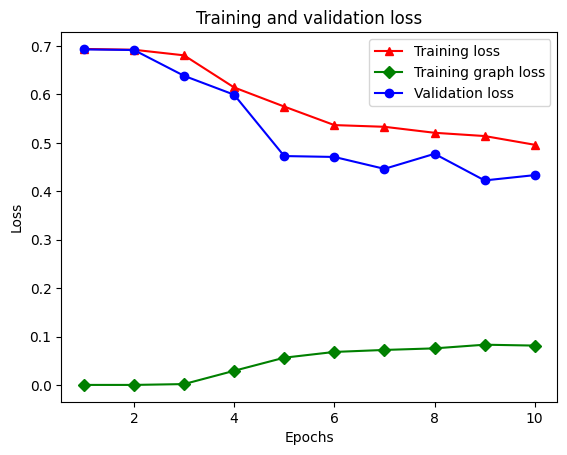

In [33]:
acc = graph_reg_history_dict['accuracy']
val_acc = graph_reg_history_dict['val_accuracy']
loss = graph_reg_history_dict['loss']
graph_loss = graph_reg_history_dict['scaled_graph_loss']
val_loss = graph_reg_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()   # clear figure

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-gD" is for solid green line with diamond markers.
plt.plot(epochs, graph_loss, '-gD', label='Training graph loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

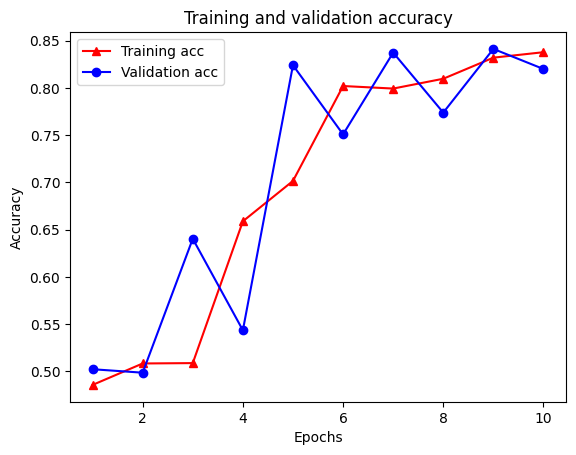

In [34]:
plt.clf()   # clear figure

plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

## The power of semi-supervised learning

Semi-supervised learning and more specifically, graph regularization in the
context of this tutorial, can be really powerful when the amount of training
data is small. The lack of training data is compensated by leveraging similarity
among the training samples, which is not possible in traditional supervised
learning.

We define ***supervision ratio*** as the ratio of training samples to the total
number of samples which includes training, validation, and test samples. In this
notebook, we have used a supervision ratio of 0.05 (i.e, 5% of the labeled data)
for training both the base model as well as the graph-regularized model. We
illustrate the impact of the supervision ratio on model accuracy in the cell
below.

<Figure size 640x480 with 0 Axes>

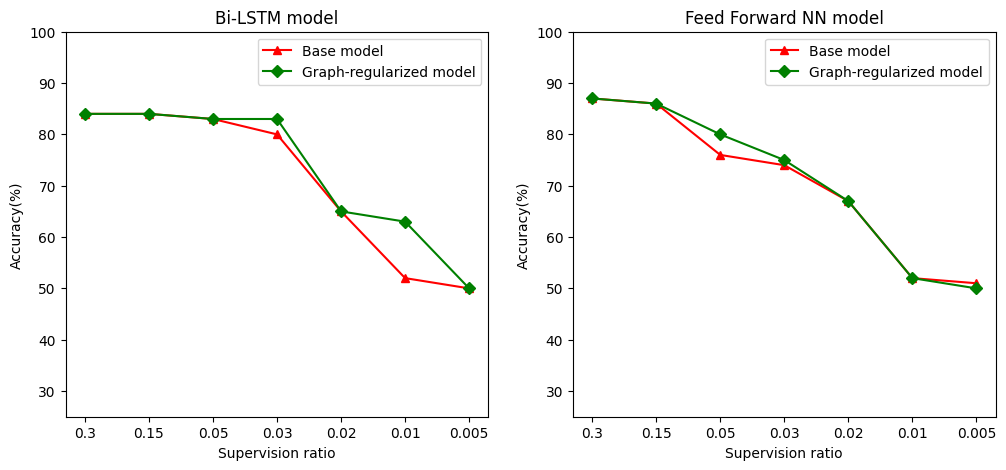

In [35]:
# Accuracy values for both the Bi-LSTM model and the feed forward NN model have
# been precomputed for the following supervision ratios.

supervision_ratios = [0.3, 0.15, 0.05, 0.03, 0.02, 0.01, 0.005]

model_tags = ['Bi-LSTM model', 'Feed Forward NN model']
base_model_accs = [[84, 84, 83, 80, 65, 52, 50], [87, 86, 76, 74, 67, 52, 51]]
graph_reg_model_accs = [[84, 84, 83, 83, 65, 63, 50],
                        [87, 86, 80, 75, 67, 52, 50]]

plt.clf()  # clear figure

fig, axes = plt.subplots(1, 2)
fig.set_size_inches((12, 5))

for ax, model_tag, base_model_acc, graph_reg_model_acc in zip(
    axes, model_tags, base_model_accs, graph_reg_model_accs):

  # "-r^" is for solid red line with triangle markers.
  ax.plot(base_model_acc, '-r^', label='Base model')
  # "-gD" is for solid green line with diamond markers.
  ax.plot(graph_reg_model_acc, '-gD', label='Graph-regularized model')
  ax.set_title(model_tag)
  ax.set_xlabel('Supervision ratio')
  ax.set_ylabel('Accuracy(%)')
  ax.set_ylim((25, 100))
  ax.set_xticks(range(len(supervision_ratios)))
  ax.set_xticklabels(supervision_ratios)
  ax.legend(loc='best')

plt.show()

It can be observed that as the superivision ratio decreases, model accuracy also
decreases. This is true for both the base model and for the graph-regularized
model, regardless of the model architecture used. However, notice that the
graph-regularized model performs better than the base model for both the
architectures. In particular, for the Bi-LSTM model, when the supervision ratio
is 0.01, the accuracy of the graph-regularized model is **~20%** higher than
that of the base model. This is primarily because of semi-supervised learning
for the graph-regularized model, where structural similarity among training
samples is used in addition to the training samples themselves.

## Conclusion

We have demonstrated the use of graph regularization using the Neural Structured
Learning (NSL) framework even when the input does not contain an explicit graph.
We considered the task of sentiment classification of IMDB movie reviews for
which we synthesized a similarity graph based on review embeddings. We encourage
users to experiment further by varying hyperparameters, the amount of
supervision, and by using different model architectures.